In [4]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
from IPython.display import Image, display

In [6]:
from atlassampler import HMC

# Ref samples
 


In [7]:
reference_samples = {}
log_scale = np.random.normal(0, 3, 500000)
latents = np.array([np.random.normal(0, np.exp(log_scale/2)) for _ in range(10)]).T
log_scale = log_scale.reshape(-1, 1)
ref_samples_funnel = np.concatenate([log_scale, latents], axis=1)
reference_samples['funnel-11'] = ref_samples_funnel

x = np.random.normal(1, 1, 500000)
y = np.array([np.random.normal(x**2, 0.1) for _ in range(2-1)]).T
x = np.expand_dims(x, axis=1)
ref_samples_rosenbrock = np.concatenate([x, y], axis=1)
reference_samples['rosenbrock-2'] = ref_samples_rosenbrock



# step size distribution

In [8]:
from atlassampler.distributions import beta_dist

In [9]:
from scipy.stats import lognorm

In [10]:
from scipy.stats import norm

class Lognorm_dist():
    
    def __init__(self, epsmean, sigma=np.log(2)):
        self.epsmean = epsmean
        self.offset = sigma**2/2
        self.mu = np.log(self.epsmean) - self.offset
        self.sigma = sigma
        self.normal_dist = norm(loc=self.mu,  scale=self.sigma)
        
    def rvs(self, n):
        y = self.normal_dist.rvs(n)
        x = np.exp(y)
        return x
    
    def logpdf(self, x):
        y = np.log(x)
        jac = 1/x #dy/dx
        lp_y = self.normal_dist.logpdf(y) 
        lp_x = lp_y + np.log(jac)
        return lp_x


In [11]:
emax = 0.5
emin = emax/500
emean = 0.1
pdfbeta = beta_dist(emean, emax, emin)
pdflg = Lognorm_dist(emean)
pdflg2 = Lognorm_dist(emean, np.log(1.2))

In [16]:
pdflg2.rvs(10000).mean(), pdflg2.rvs(10000).std(), np.log(1.2)

(0.09996801590785667, 0.018277849546395688, 0.1823215567939546)

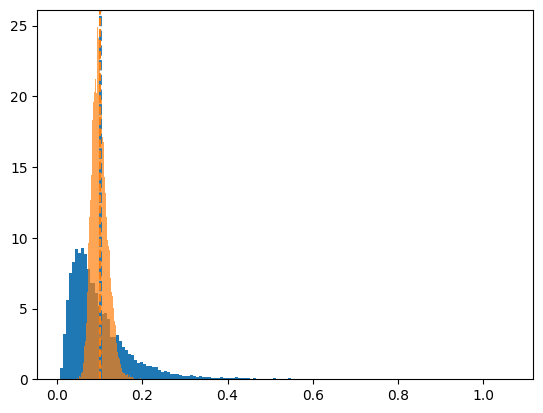

In [12]:
# pdflg = lognorm(s=0.1, loc=-np.log(emean))
plt.hist(pdflg.rvs(10000), density=True, bins='auto')
plt.axvline(pdflg.rvs(10000).mean(), color='C0', ls="--", lw=2)
plt.hist(pdflg2.rvs(10000), density=True, bins='auto', alpha=0.7)
plt.axvline(pdflg2.rvs(10000).mean(), color='C1', ls="--")


In [ ]:
plt.hist(pdfbeta.rvs(10000), density=True, bins='auto')
plt.axvline(pdfbeta.rvs(10000).mean(), color='C0', ls="--", lw=2)

# offset = np.log(2)**2/2
# plt.hist(exp(np.random.normal(np.log(emean)-offset, log(2), 10000)), density=True, bins='auto', alpha=0.7)
# plt.axvline(exp(np.random.normal(np.log(emean)-offset, log(2), 10000)).mean(), color='C1', ls="--", lw=2)
plt.hist(pdflg.rvs(10000), density=True, bins='auto', alpha=0.5)
plt.axvline(pdflg.rvs(10000).mean(), color='C1', ls="--", lw=2)
plt.axvline(emax, color='k')
plt.axvline(emin, color='k')
plt.axvline(emean, color='k', ls="-", lw=2, alpha=0.5)
plt.xlim(-0.1, 1)

In [144]:
x = np.linspace(0.1, 0.45, 10)
x, pdfbeta.logpdf(x)

(array([0.1       , 0.13888889, 0.17777778, 0.21666667, 0.25555556,
        0.29444444, 0.33333333, 0.37222222, 0.41111111, 0.45      ]),
 array([ 1.68413921,  1.33063044,  0.86439859,  0.28916908, -0.40859425,
        -1.25896001, -2.31678079, -3.68518045, -5.58509376, -8.63770329]))

In [147]:
x, pdflg.logpdf(x)

(array([0.1       , 0.13888889, 0.17777778, 0.21666667, 0.25555556,
        0.29444444, 0.33333333, 0.37222222, 0.41111111, 0.45      ]),
 array([ 1.69010285,  1.08504137,  0.48254438, -0.09182669, -0.63346811,
        -1.1434523 , -1.62438109, -2.07909775, -2.51027512, -2.9203005 ]))

In [148]:

pdflg = Lognorm_dist(emean)
x, pdflg.logpdf(x)

(array([0.1       , 0.13888889, 0.17777778, 0.21666667, 0.25555556,
        0.29444444, 0.33333333, 0.37222222, 0.41111111, 0.45      ]),
 array([-0.61248224, -0.88903966, -1.24467656, -1.62122189, -1.99778356,
        -2.36611723, -2.72299338, -3.06736199, -3.39916688, -3.71880819]))

In [341]:
pdflg = Lognorm_dist(emean, sigma=np.log(1.2))
x = pdflg.rvs(100000)

In [342]:
((x > emean/5) & (x < 5*emean)).sum()/x.size

1.0

In [343]:
((x > emean/2) & (x < 2*emean)).sum()/x.size

0.9998

In [344]:
((x > emean/1.5) & (x < 1.5*emean)).sum()/x.size

0.97332

In [345]:
((x > emean/1.2) & (x < 1.2*emean)).sum()/x.size

0.68127

# Check runs

In [76]:
sys.path.append('../experiments/')
import diagnostics_jax as dg

In [63]:
nchains = 16
nsamples = 4999
# exp = "rosenbrock-2"
exp = "funnel-11"
# exp = "irt_2pl"
if exp == 'funnel-11' or exp == 'rosenbrock-2':
    nsamples = 19999
if exp == 'irt_2pl' or exp == 'stochastic_volatility':
    nsamples = 2000
ref = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//{exp}/samples.npy')
if 'funnel2' in exp: ref = np.concatenate([np.repeat(ref[:, 0:1], int(exp.split('-')[1])/10, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/10*9, axis=1)], axis=1)
elif 'funnel' in exp: ref = np.concatenate([ref[:, 0:1], np.repeat(ref[:, 1:2], int(exp.split('-')[1])-1, axis=1)], axis=1)
elif 'rosenbrock' in exp: ref = np.concatenate([ np.repeat(ref[:, 0:1], int(exp.split('-')[1])/2, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/2, axis=1)], axis=1)
print('ref shape : ', ref.shape)
relative1 = 'scatter'
relative2 = 'scatter'
nevals = None
data = {}

ta = 0.8
snuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/samples.npy')[:nchains, :nsamples]
gnuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/leapfrogs.npy')[:nchains, :nsamples]
count, err1 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
count, err2 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
data['nuts'] = [count, err1, err2, snuts]


for ta in [0.8, 0.9, 0.95]:
    snuts = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/nuts/target{ta:0.2f}/samples.npy')[:nchains, :nsamples]
    gnuts = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/nuts/target{ta:0.2f}/leapfrogs.npy')[:nchains, :nsamples]
    count, err1 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
    count, err2 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
    data[f'nuts{ta:0.2f}'] = [count, err1, err2, snuts]


ref shape :  (10000000, 11)


In [64]:
def get_data(path):   
    try:
        suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])
        guturn = np.stack([np.load(f'{path}/gradcounts-{i}.npy')[:nsamples] for i in range(nchains)])
        count, err1 = dg.cumulative_rmse_per_chain(suturn, counts=guturn, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
        count, err2 = dg.cumulative_rmse_per_chain(suturn, counts=guturn, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
        assert suturn.shape[0] == nchains
        assert suturn.shape[1] == nsamples
    except Exception as e:
        print("exception : ", e)
        count, err1, err2, suturn = np.NaN, np.NaN, np.NaN, None        
    return count, err1, err2, suturn

algfolder = 'atlas-nuts' 
for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal',  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
    for offset in [0.33, 0.5, 0.66, 1.0]:
        key = f"off{offset:0.2f}{suffix}"
        path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
        print(key, path)
        tmp = get_data(path)
        if tmp[-1] is not None: data[key] = tmp

algfolder = 'atlas-nuts-indep' 
for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal',  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
    for offset in [0.33, 0.5, 0.66, 1.0]:
        key = f"off{offset:0.2f}{suffix}-indep"
        path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
        print(key, path)
        tmp = get_data(path)
        if tmp[-1] is not None: data[key] = tmp


off0.33-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.33-prob1-ctraj1/
off0.50-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.50-prob1-ctraj1/
off0.66-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.66-prob1-ctraj1/
off1.00-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset1.00-prob1-ctraj1/
off0.33-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.33-prob1-ctraj1-lognormal/
off0.50-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.50-prob1-ctraj1-lognormal/
off0.66-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.66-prob1-ctraj1-lognormal/
off1.00-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset1.00-prob1-ctraj1-lognormal/
off0.33-prob1-ctraj1-stepfac2 /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset0.3

In [53]:

# # algfolder = 'atlas-uturn' 
# # for suffix in [ '-prob1', '-prob1-lognormal']: 
# #     for offset in [0.33, 0.5, 0.66, 1.0]:
# #         key = f"ut-off{offset:0.2f}{suffix}"
# #         path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
# #         print(key, path)
# #         tmp = get_data(path)
# #         if tmp[-1] is not None: data[key] = tmp

# algfolder = 'atlas-uturn' 
# for offd in [0.33, 0.5, 0.66, 1.0]:
#     for suffix in [ '-prob1', '-prob1-lognormal']: 
#         for offset in [0.33, 0.5, 0.66, 1.0]:
#             key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
#             print(key, path)
#             tmp = get_data(path)
#             if tmp[-1] is not None: data[key] = tmp


In [54]:
# algfolder = 'atlas-hmc' 
# for suffix in ['-lognormal', '-sinitfac2.0-lognormal', '-lognormal-stepsig1.2', '-sinitfac2.0-lognormal-stepsig1.2', '-lognormal-stepsig1.5', '-sinitfac2.0-lognormal-stepsig1.5']: 
#     for offset in [0.33, 0.5, 0.66, 1.0]:
#         key = f"nodr-off{offset:0.2f}{suffix}"
#         path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#         print(key, path)
#         tmp = get_data(path)
#         if tmp[-1] is not None: data[key] = tmp


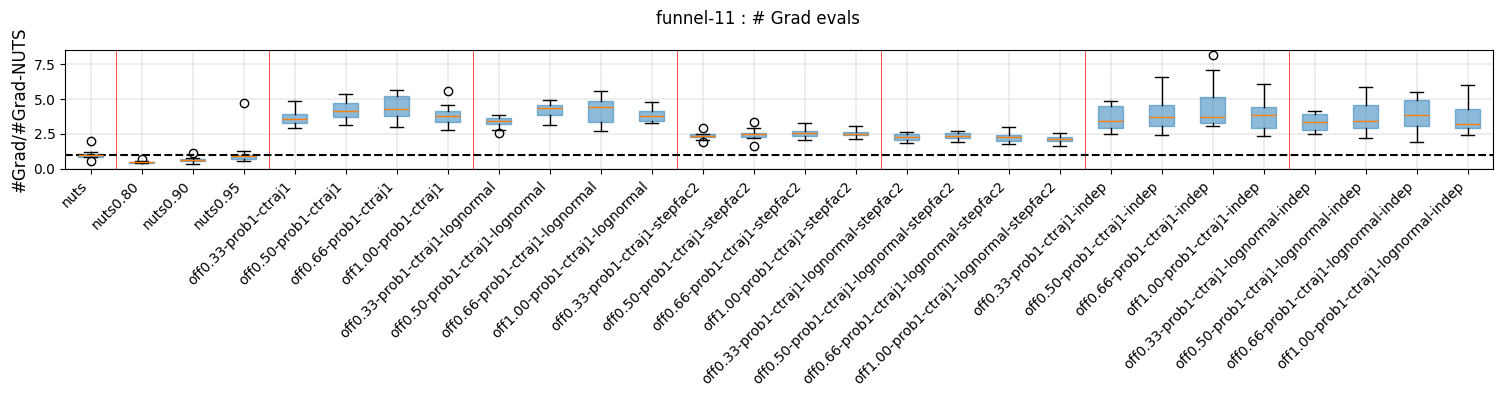

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=True)
ax = [ax]
toplot, toplot2, lbls = [], [], []
for key in data.keys():
    toplot.append(data[key][0][:, -1]/data['nuts'][0][:, -1].mean(axis=0))
    lbls.append(key)

ax[0].boxplot(toplot, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);

for axis in [ax[0]]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')
# plt.boxplot(suturn.std(axis=1)[:, d], patch_artist=True,
#             boxprops=dict(facecolor='C1', color='C1'), labels=[1]);

for axis in ax:
    axis.axvline(1.5, color='r', lw=0.5)
    for j in range(int(len(toplot)/4)):
        axis.axvline(4.5 + j*4, color='r', lw=0.5)
    # axis.axvline(4.5, color='r', lw=0.5)
    # axis.axvline(7.5, color='r', lw=0.5)
    # axis.axvline(10.5, color='r', lw=0.5)
    # axis.axvline(14.5, color='r', lw=0.5)
    axis.axhline(1, color='k', ls="--")
    axis.grid(which='both', lw=0.3)
    
# ax[0].set_ylim(0, 4)
ax[0].set_ylabel(r'#Grad/#Grad-NUTS', fontsize=12)
plt.suptitle(f'{exp} : # Grad evals')
plt.tight_layout()

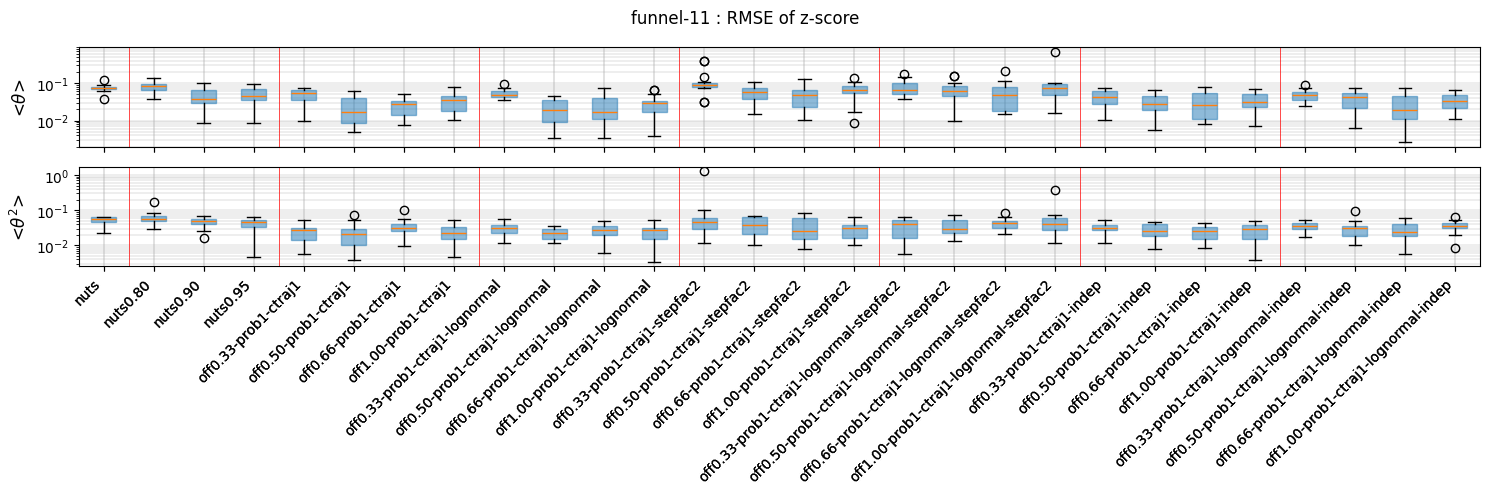

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

toplot, toplot2, lbls = [], [], []
for key in data.keys():
    toplot.append([d[-1] for d in data[key][1]])
    toplot2.append([d[-1] for d in data[key][2]])
    # toplot.append(data[key][1][:, -1])
    # toplot2.append(data[key][2][:, -1])
    lbls.append(key)

ax[0].boxplot(toplot, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
ax[1].boxplot(toplot2, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);

for axis in [ax[1]]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')
# plt.boxplot(suturn.std(axis=1)[:, d], patch_artist=True,
#             boxprops=dict(facecolor='C1', color='C1'), labels=[1]);

for axis in ax:
    axis.axvline(1.5, color='r', lw=0.5)
    for j in range(int(len(toplot)/4)):
        axis.axvline(4.5 + j*4, color='r', lw=0.5)
    # axis.axvline(4.5, color='r', lw=0.5)
    # axis.axvline(7.5, color='r', lw=0.5)
    # axis.axvline(10.5, color='r', lw=0.5)
    # axis.axvline(14.5, color='r', lw=0.5)
    axis.grid(which='both', lw=0.3)
    axis.set_yscale('log')
    # axis.set_ylim(1e-2, 1e-1)
# ax[0].axhline(mean(toplot[0]), color='k', ls="--")
# ax[1].axhline(mean(toplot2[0]), color='k', ls="--")
    
ax[0].set_ylabel(r'<$\theta$>', fontsize=12)
ax[1].set_ylabel(r'<$\theta^2$>', fontsize=12)
plt.suptitle(f'{exp} : RMSE of z-score')
plt.tight_layout()

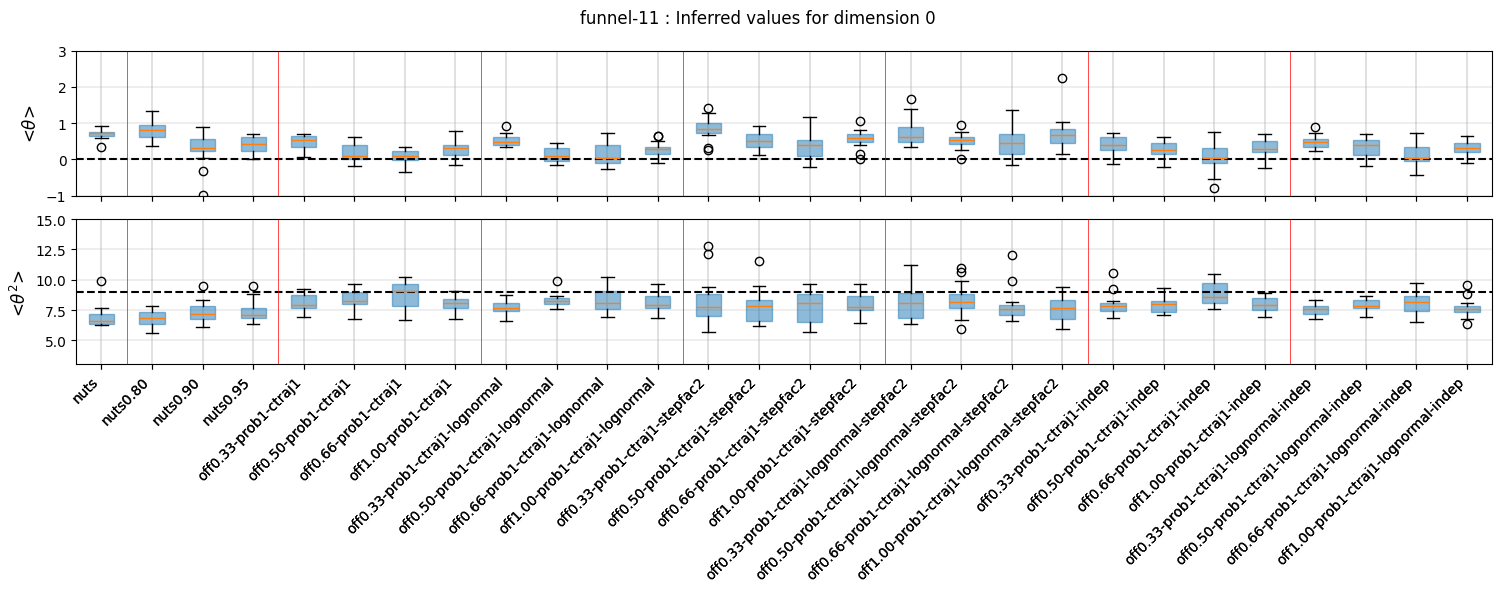

In [57]:
d = 0
# 
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

toplot, toplot2, lbls = [], [], []
ikey = 0
for key in data.keys():
    # if not "off1" in key: continue
    toplot.append(data[key][-1].mean(axis=1)[:, d])
    toplot2.append((data[key][-1]**2).mean(axis=1)[:, d])
    lbls.append(key)


ax[0].boxplot(toplot, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
ax[1].boxplot(toplot2, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
ax[0].axhline(ref[..., d].mean(), color='k', ls="--")
ax[1].axhline((ref[..., d]**2).mean(), color='k', ls="--")
for axis in [ax[1]]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

for axis in ax:
    axis.axvline(1.5, color='r', lw=0.5)
    for j in range(int(len(toplot)/4)):
        axis.axvline(4.5 + j*4, color='r', lw=0.5)
    axis.grid(which='both', lw=0.3)

if 'funnel' in exp:
    ax[0].set_ylim(-1, 3)
    ax[1].set_ylim(3, 15)
ax[0].set_ylabel(r'<$\theta$>', fontsize=12)
ax[1].set_ylabel(r'<$\theta^2$>', fontsize=12)
plt.suptitle(f'{exp} : Inferred values for dimension {d}')

plt.tight_layout()

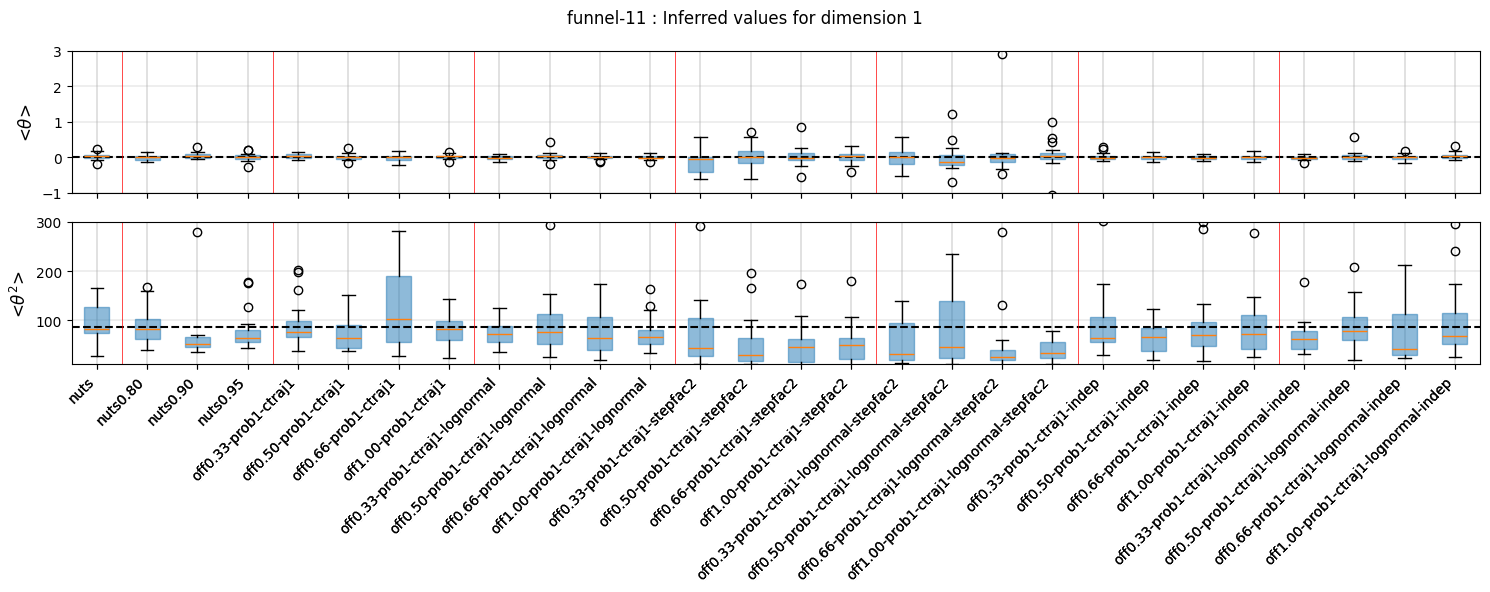

In [58]:
d = 1
# 
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

toplot, toplot2, lbls = [], [], []
ikey = 0
for key in data.keys():
    toplot.append(data[key][-1].mean(axis=1)[:, d])
    toplot2.append((data[key][-1]**2).mean(axis=1)[:, d])
    lbls.append(key)


ax[0].boxplot(toplot, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
ax[1].boxplot(toplot2, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
ax[0].axhline(ref[..., d].mean(), color='k', ls="--")
ax[1].axhline((ref[..., d]**2).mean(), color='k', ls="--")
for axis in [ax[1]]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

for axis in ax:
    axis.axvline(1.5, color='r', lw=0.5)
    for j in range(int(len(toplot)/4)):
        axis.axvline(4.5 + j*4, color='r', lw=0.5)
    axis.grid(which='both', lw=0.3)

if 'funnel' in exp:
    ax[0].set_ylim(-1, 3)
    ax[1].set_ylim(10, 300)
if 'rosenbrock' in exp:
    ax[0].set_ylim(0, 5)
    ax[1].set_ylim(0, 30)
ax[0].set_ylabel(r'<$\theta$>', fontsize=12)
ax[1].set_ylabel(r'<$\theta^2$>', fontsize=12)
plt.suptitle(f'{exp} : Inferred values for dimension {d}')

plt.tight_layout()

dims after index : 1


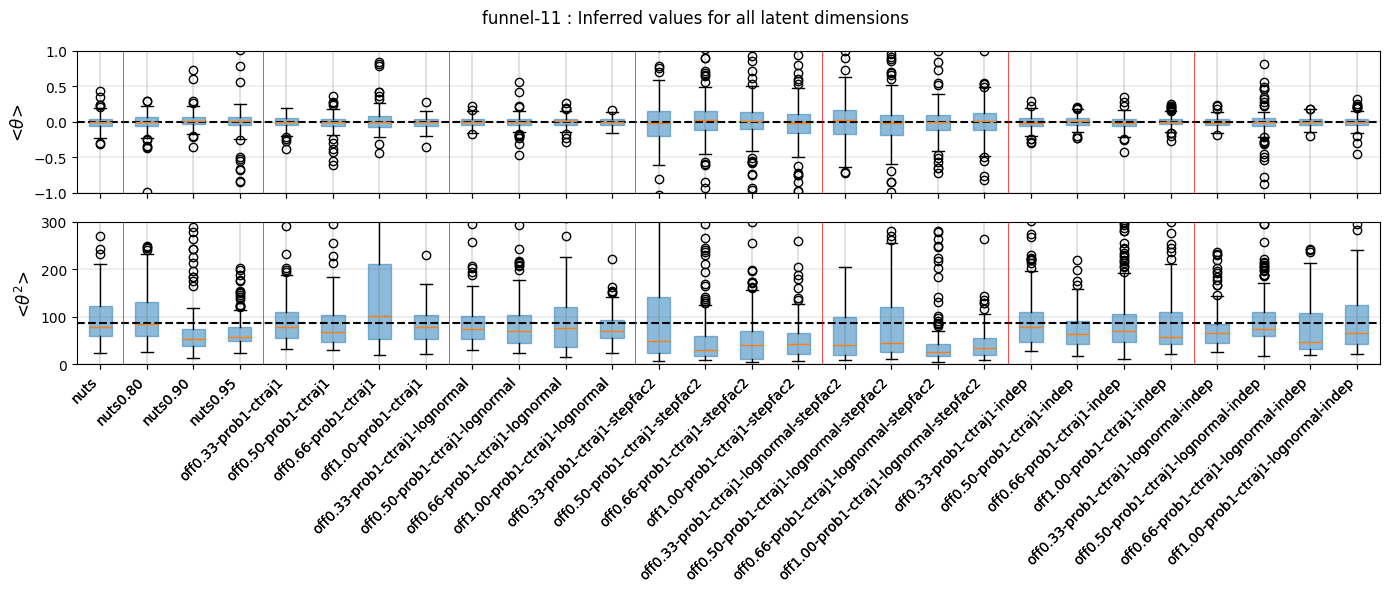

In [59]:
# 
if ('funnel' in exp) :
    toplot, toplot2, lbls = [], [], []
    ikey = 0
    d = 1 
    if "funnel2" in  exp: d = int(exp.split('-')[1])//10
    print("dims after index :", d)
    
    for key in data.keys():
        # if 'lognormal' in key: continue
        
        toplot.append(data[key][-1].mean(axis=1)[:, d:].flatten())
        toplot2.append((data[key][-1]**2).mean(axis=1)[:, d:].flatten())
        lbls.append(key)
        if 'dist' not in key: ikey += 1 

    fig, ax = plt.subplots(2, 1, figsize=(len(toplot)/2, 6), sharex=True)
    ax[0].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
    ax[1].boxplot(toplot2, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
    d = -1
    ax[0].axhline(ref[..., d].mean(), color='k', ls="--")
    ax[1].axhline((ref[..., d]**2).mean(), color='k', ls="--")
    for axis in [ax[1]]:
        axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

    for axis in ax:
        axis.axvline(1.5, color='r', lw=0.5)
        # for j in range(int(len(data.keys())/4)):
        for j in range(int(len(toplot)/4)):
            axis.axvline(4.5 + j*4, color='r', lw=0.5)
        axis.grid(which='both', lw=0.3)

    ax[0].set_ylim(-1, 1)
    ax[1].set_ylim(0, 300)
    ax[0].set_ylabel(r'<$\theta$>', fontsize=12)
    ax[1].set_ylabel(r'<$\theta^2$>', fontsize=12)
    plt.suptitle(f'{exp} : Inferred values for all latent dimensions')

    plt.tight_layout()
else:
    print("only for funnel")

[]

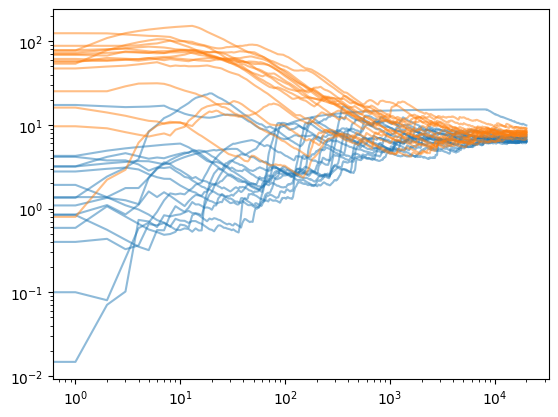

In [65]:
# plt.plot(data['nuts'][0].T, data['nuts'][2].T, 'C0', alpha=0.5)
# plt.plot(data['off1.00-prob1-ctraj1'][0].T, data['off1.00-prob1-ctraj1'][2].T, 'C1', alpha=0.5)
# plt.loglog()

# plt.plot(data['nuts'][0].T, (np.cumsum(data['nuts'][3][..., 0], axis=1)/(1+np.arange(nsamples))).T, 'C0', alpha=0.5)
# key = 'off1.00-prob1-ctraj1'
# plt.plot(data[key][0].T, (np.cumsum(data[key][3][..., 0], axis=1)/(1+np.arange(data[key][0].shape[1]))).T, 'C1', alpha=0.5)

# plt.plot((np.cumsum(data['nuts'][3][..., 0], axis=1)/(1+np.arange(nsamples))).T, 'C0', alpha=0.5)
# key = 'off1.00-prob1-ctraj1'
# plt.plot( (np.cumsum(data[key][3][..., 0], axis=1)/(1+np.arange(data[key][0].shape[1]))).T, 'C1', alpha=0.5)

plt.plot((np.cumsum(data['nuts'][3][..., 0]**2, axis=1)/(1+np.arange(nsamples))).T, 'C0', alpha=0.5)
key = 'off1.00-prob1-ctraj1'
plt.plot( (np.cumsum(data[key][3][..., 0]**2, axis=1)/(1+np.arange(data[key][0].shape[1]))).T, 'C1', alpha=0.5);

plt.loglog()
# plt.semilogx()

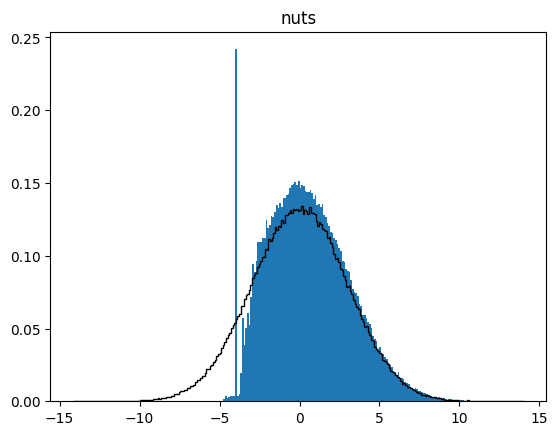

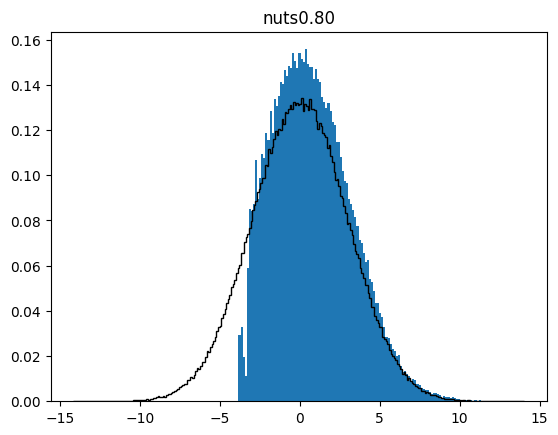

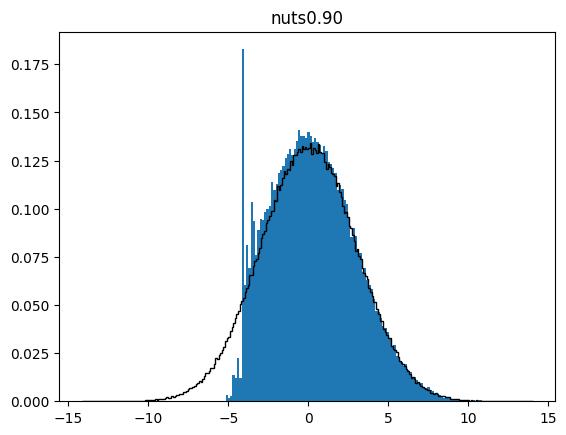

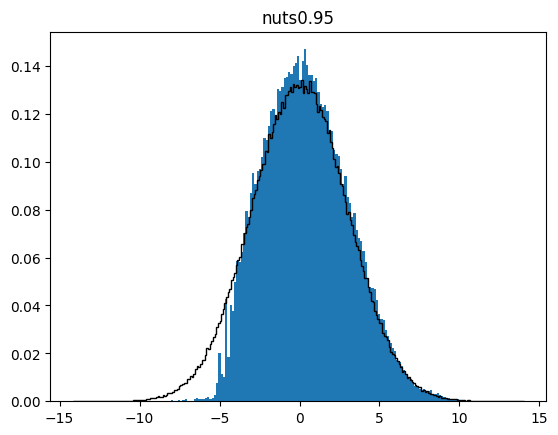

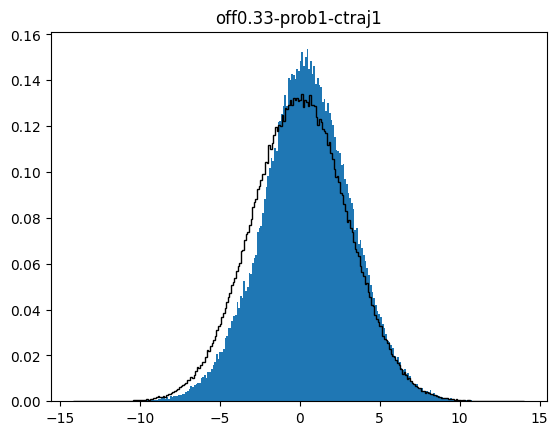

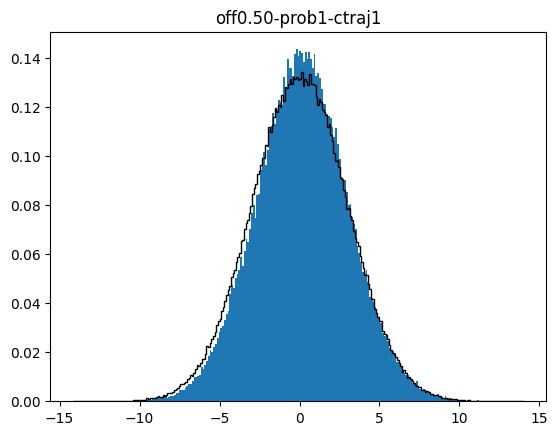

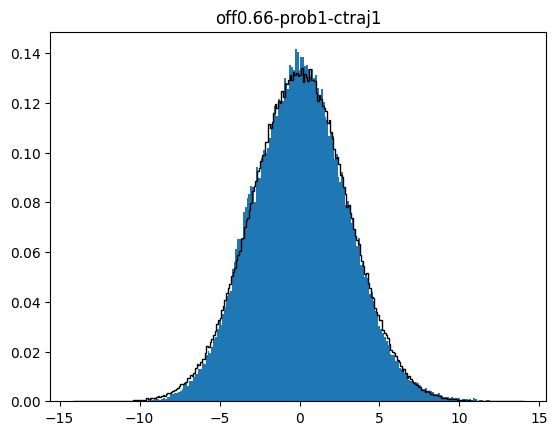

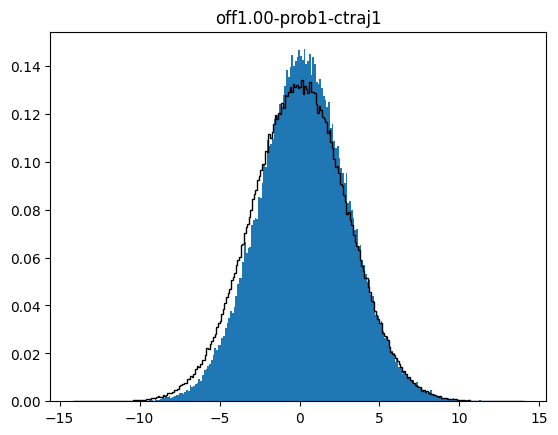

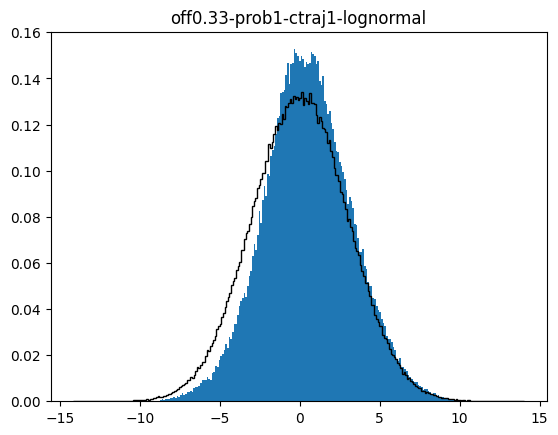

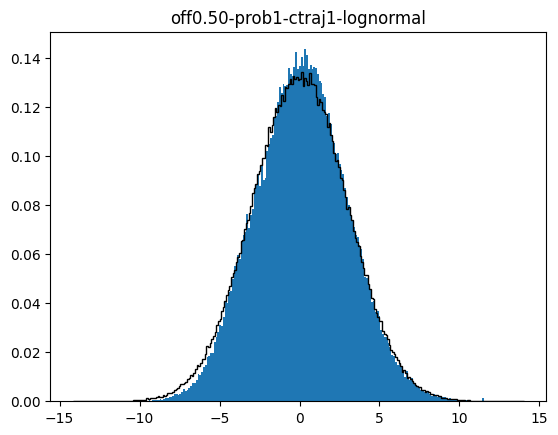

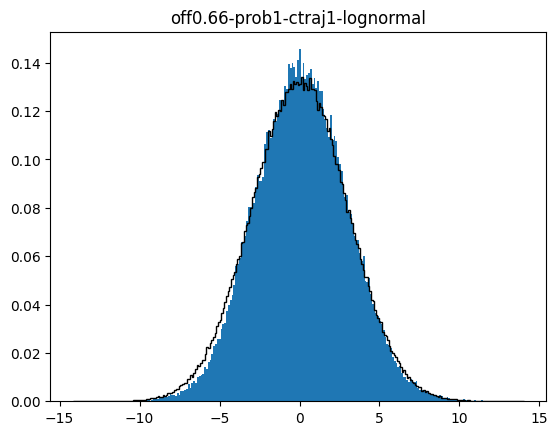

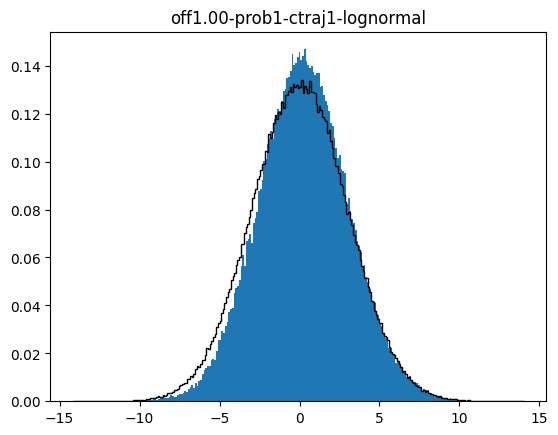

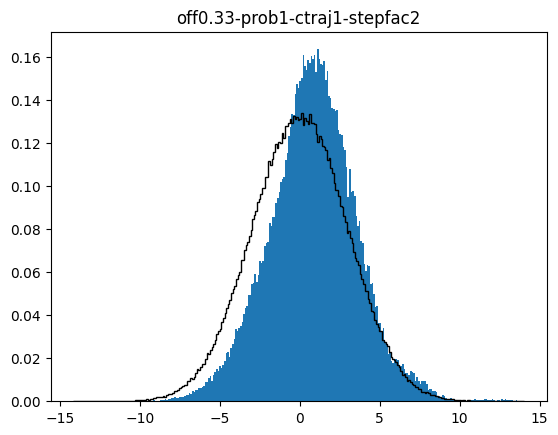

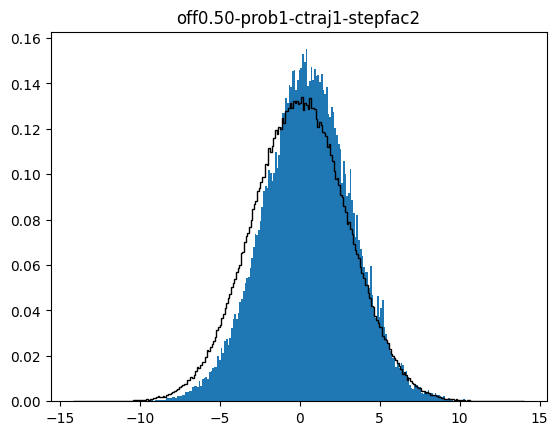

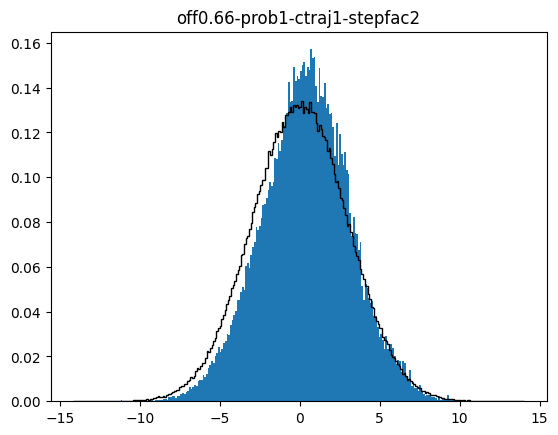

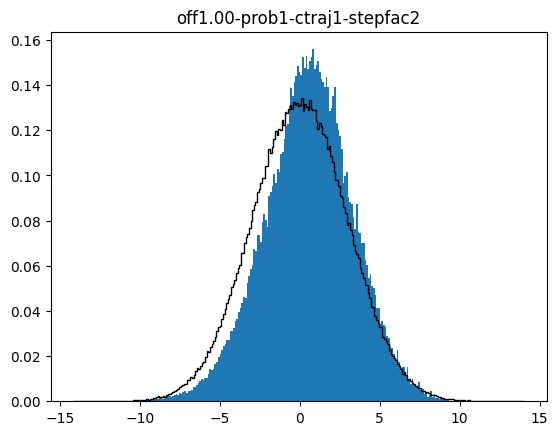

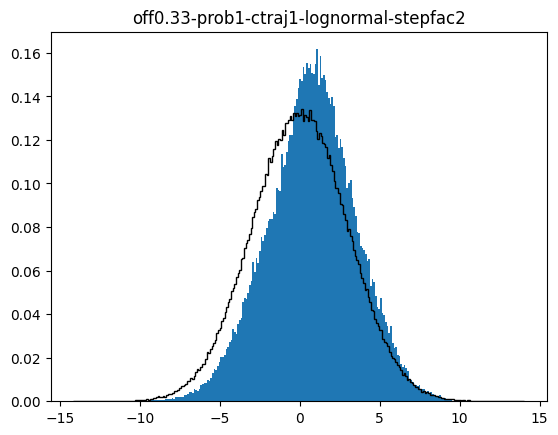

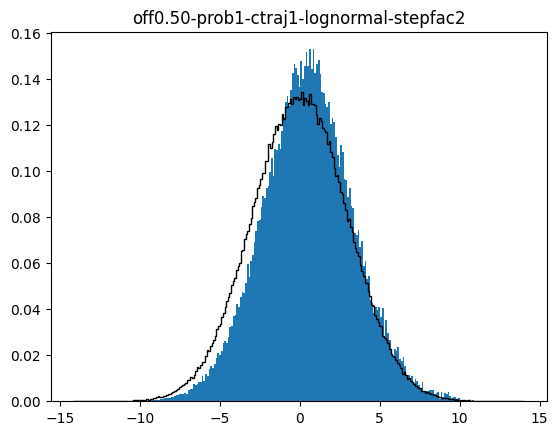

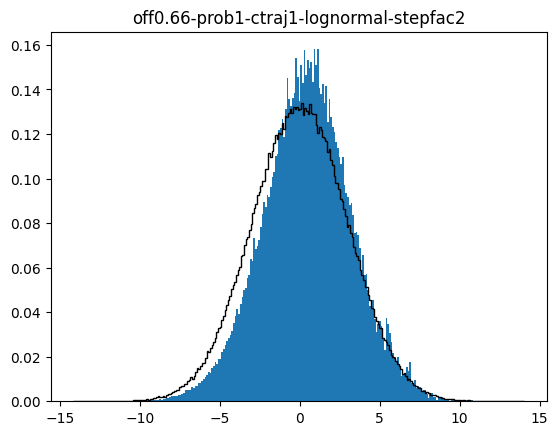

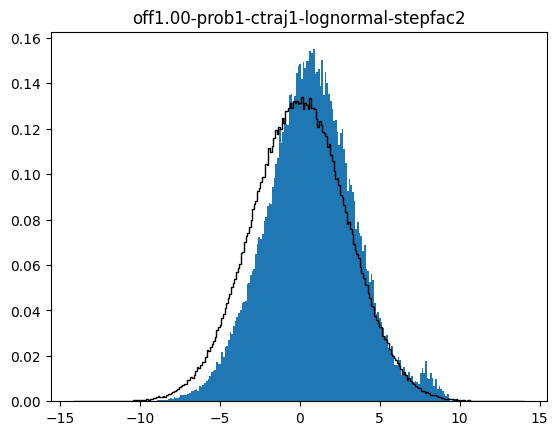

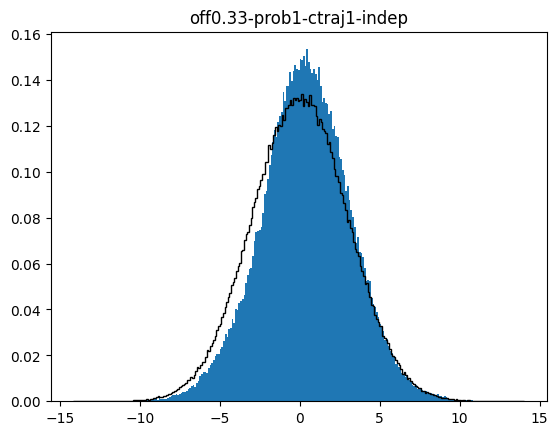

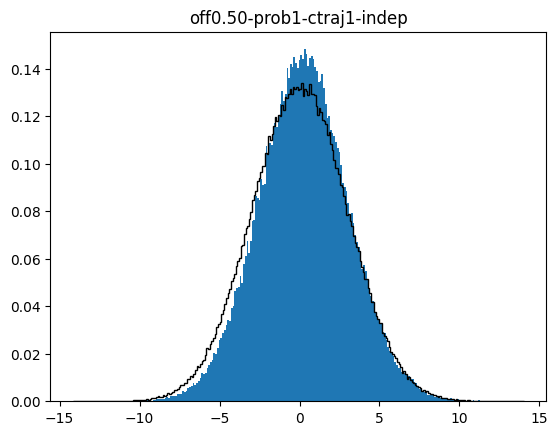

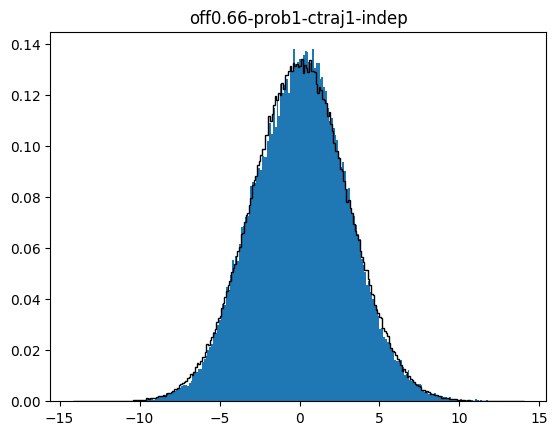

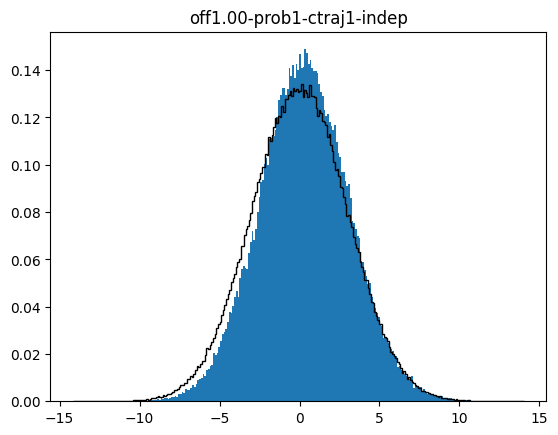

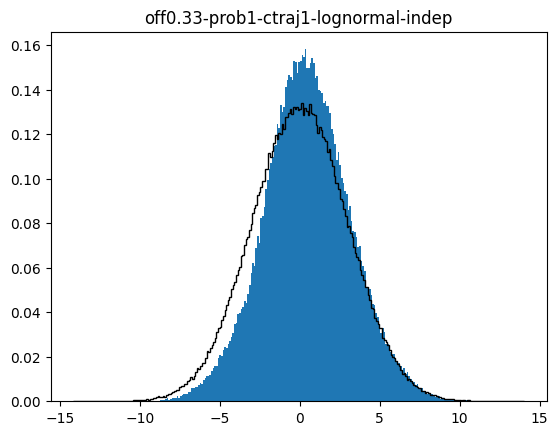

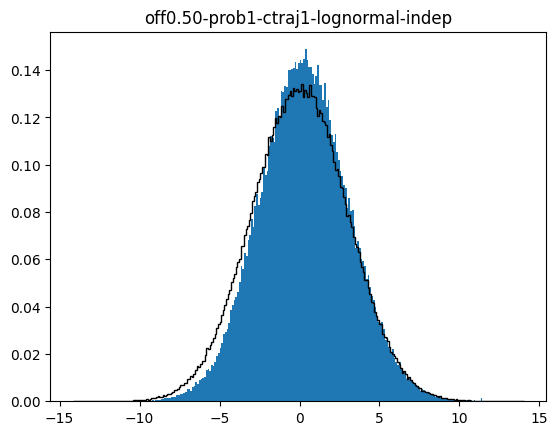

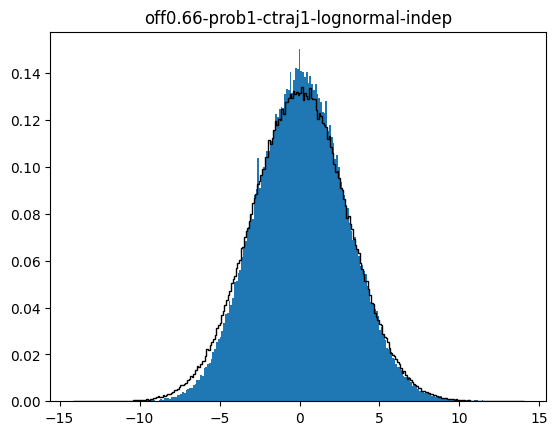

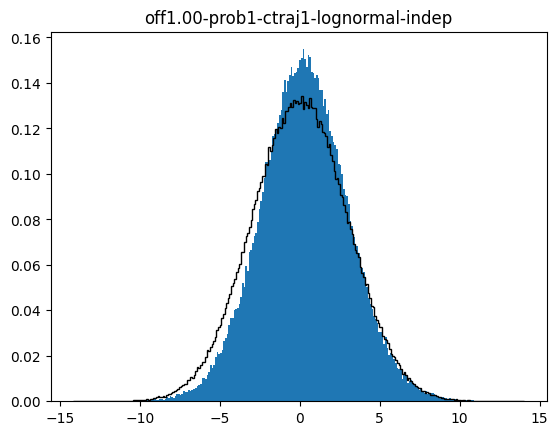

In [66]:
for key in data.keys():
    plt.hist(reference_samples[exp][..., 0], density=True, color='k', lw=1, histtype='step', bins='auto')
    plt.hist(data[key][-1][..., 0].flatten(), density=True,  bins='auto')
    plt.title(key)
    plt.show()

In [1]:
256*3000

768000

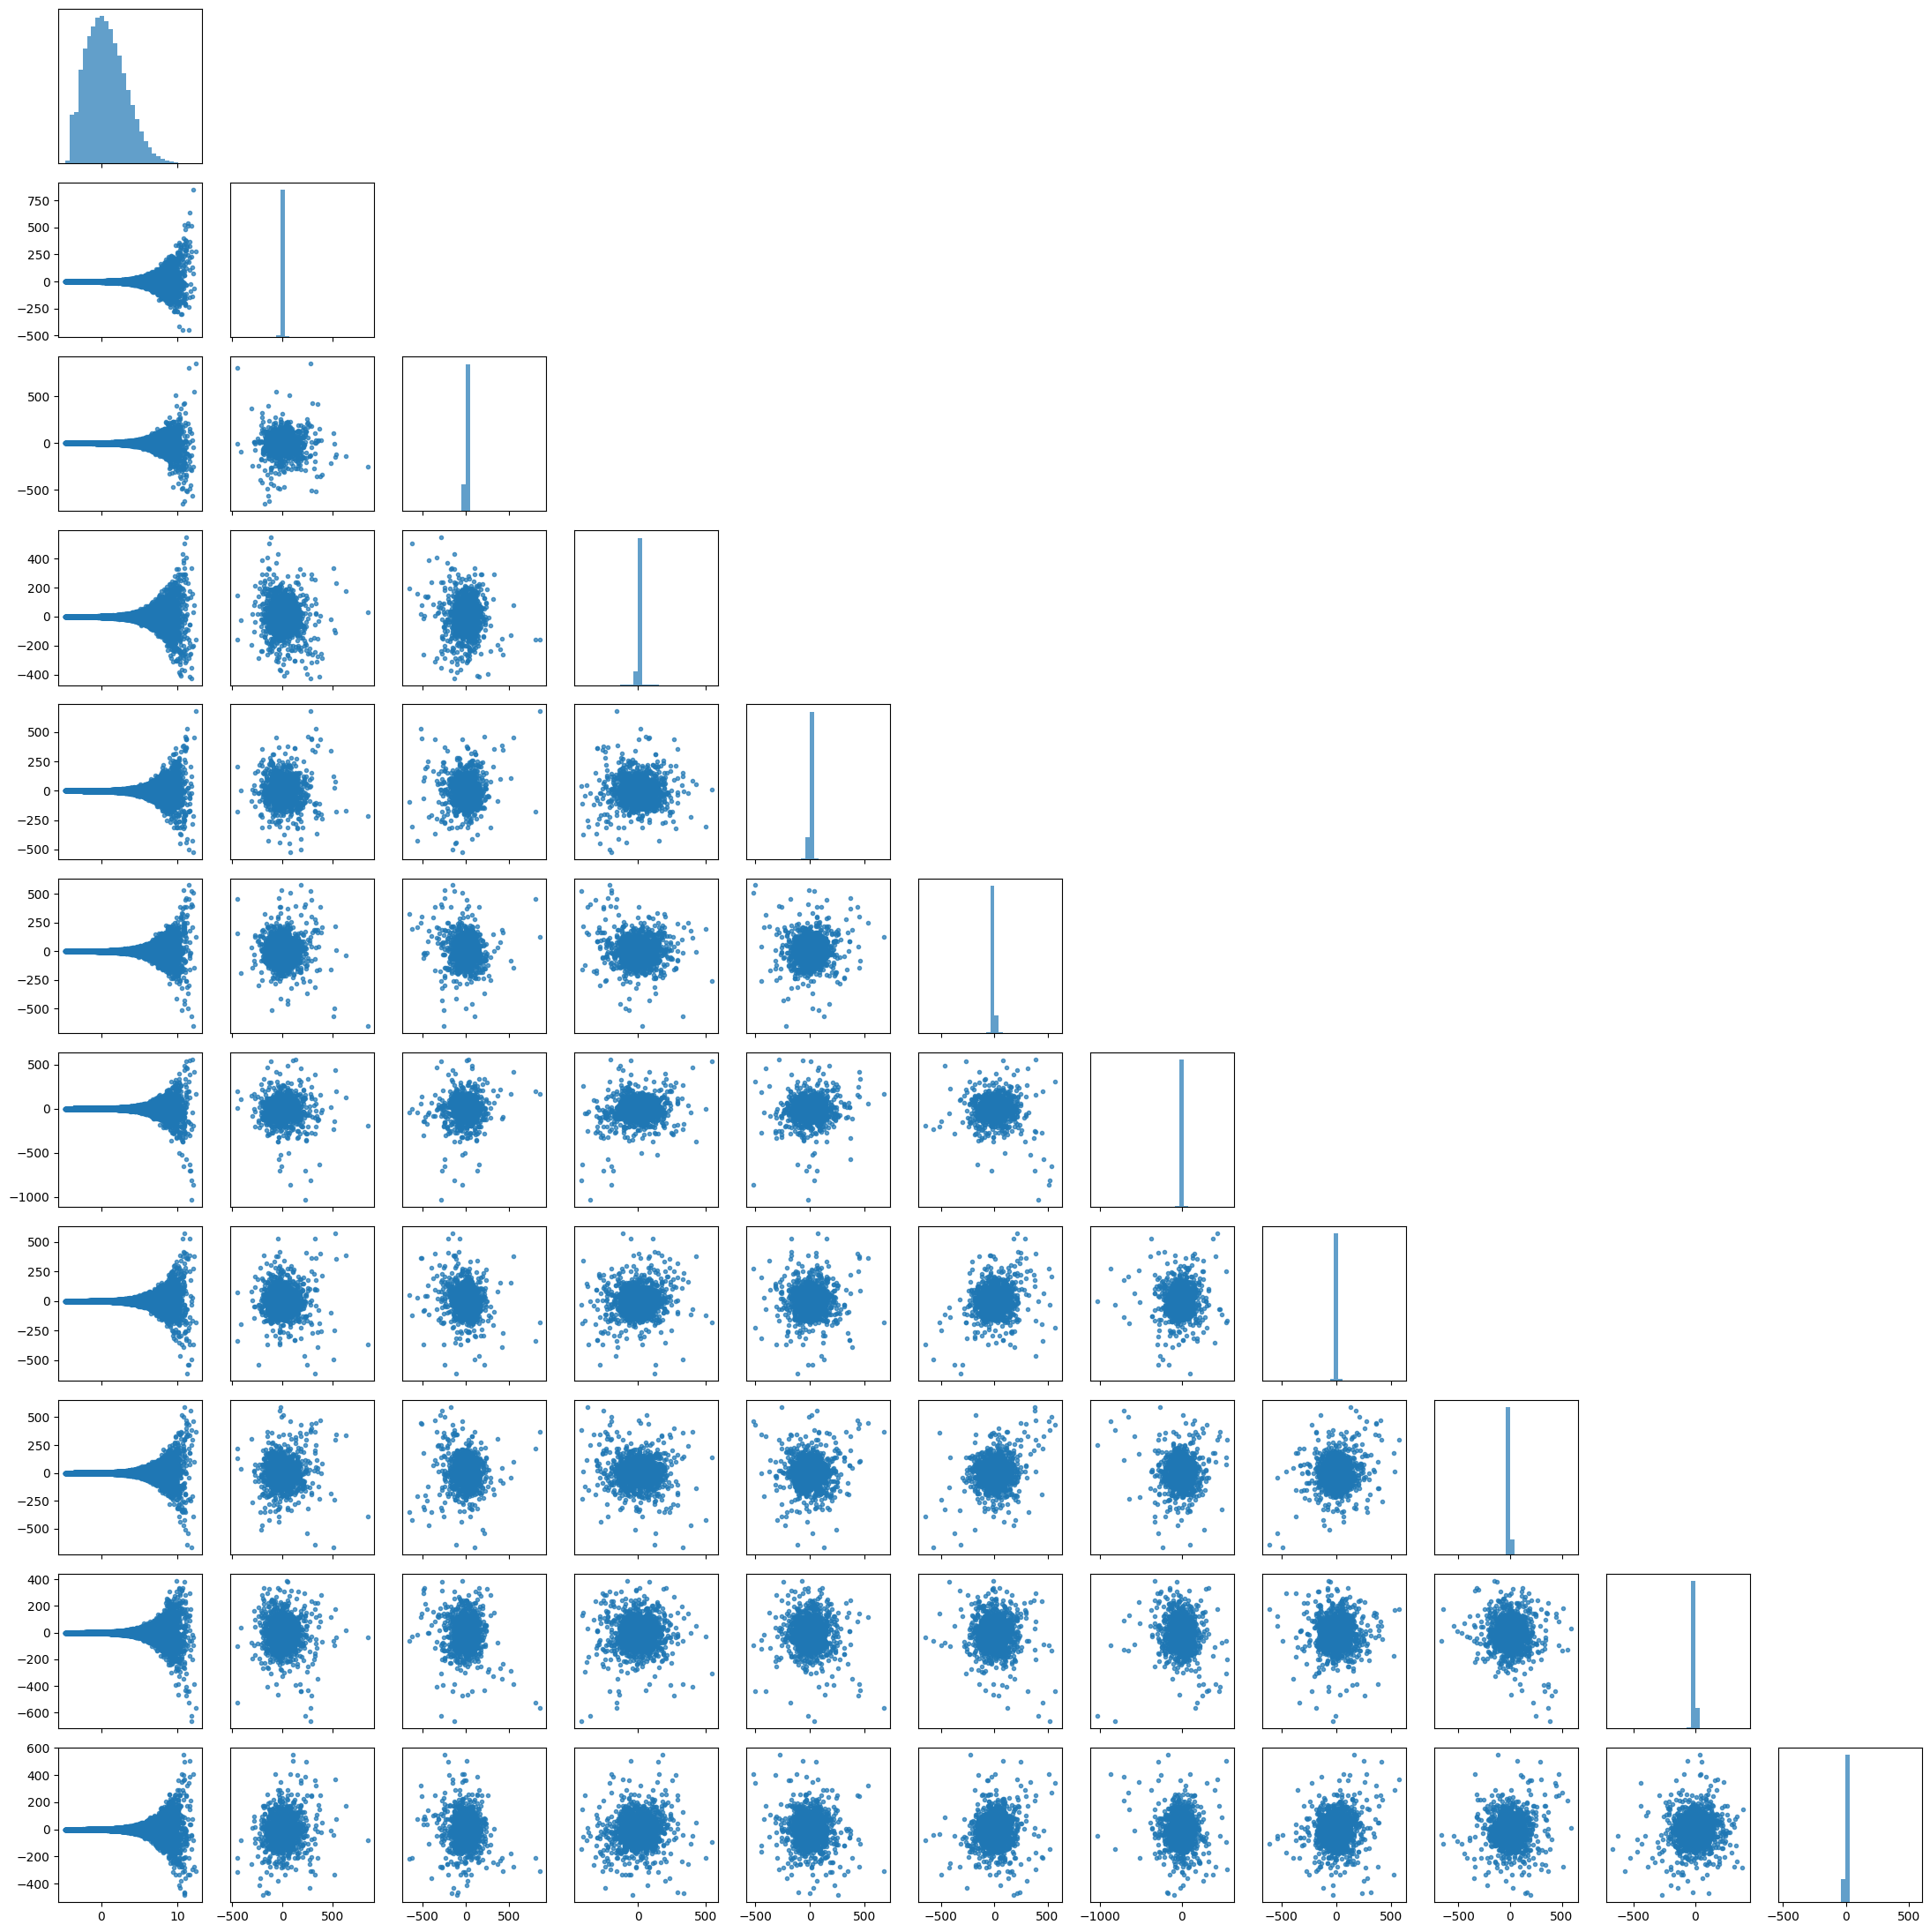

In [62]:
s = data['nuts'][-1]
D = s.shape[-1]
fig, ax = plt.subplots(D, D, figsize=(D*2, D*2), sharex='col')
                       
for d in range(D):
    for i in range(d, D):
        if i == d:
            ax[d, d].hist(s[..., d].flatten(), alpha=0.7, density=True, bins=30, label='NUTS')
            ax[d, d].get_yaxis().set_ticks([])
        else:
            ax[i, d].plot(s[..., d].flatten(), s[..., i].flatten(), '.', alpha=0.7)
            ax[d, i].axis('off')
            if d >0  : ax[i, d].get_yaxis().set_ticks([])

# ax[0, 0].legend(fontsize=11)
# for ia, axis in enumerate(ax[:, 0]): 
#     axis.set_ylabel(var_names2[ia], fontsize=12)
# for ia, axis in enumerate(ax[-1, :]): 
#     axis.set_xlabel(var_names2[ia], fontsize=12)
plt.tight_layout()

# Compare configs

In [315]:
nchains = 16
nsamples = 4999 
relative1 = 'scatter'
relative2 = 'scatter'
nevals = None

alldata = {}

for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
    # ref = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//{exp}/samples.npy')
    # if 'funnel2' in exp: ref = np.concatenate([np.repeat(ref[:, 0:1], int(exp.split('-')[1])/10, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/10*9, axis=1)], axis=1)
    # elif 'funnel' in exp: ref = np.concatenate([ref[:, 0:1], np.repeat(ref[:, 1:2], int(exp.split('-')[1])-1, axis=1)], axis=1)
    # elif 'rosenbrock' in exp: ref = np.concatenate([ np.repeat(ref[:, 0:1], int(exp.split('-')[1])/2, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/2, axis=1)], axis=1)
    # print('ref shape : ', ref.shape)
    data = {}

    ref = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//{exp}/samples.npy')
    if 'funnel2' in exp: ref = np.concatenate([np.repeat(ref[:, 0:1], int(exp.split('-')[1])/10, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/10*9, axis=1)], axis=1)
    elif 'funnel' in exp: ref = np.concatenate([ref[:, 0:1], np.repeat(ref[:, 1:2], int(exp.split('-')[1])-1, axis=1)], axis=1)
    elif 'rosenbrock' in exp: ref = np.concatenate([ np.repeat(ref[:, 0:1], int(exp.split('-')[1])/2, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/2, axis=1)], axis=1)

    
    ta = 0.8
    snuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/samples.npy')[:nchains, :nsamples]
    gnuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/leapfrogs.npy')[:nchains, :nsamples]
    count, err1 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
    count, err2 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
    data['nuts'] = [count, err1, err2, snuts]

    for ta in [0.8,0.95]:
        snuts = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/nuts/target{ta:0.2f}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/nuts/target{ta:0.2f}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
        count, err2 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
        data[f'nuts{ta:0.2f}'] = [count, err1, err2, snuts]
        

    algfolder = 'atlas-nuts' 
    for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal']: 
        # for offset in [0.33, 0.5, 0.66, 1.0]:
        for offset in [1.0]:
            key = f"off{offset:0.2f}{suffix}"
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            tmp = get_data(path)
            if tmp[-1] is not None: data[key] = tmp

            
    algfolder = 'atlas-uturn' 
    for offd in [0.33, 0.5, 0.66, 1.0]:
        for suffix in [ '-prob1', '-prob1-lognormal']: 
            for offset in [ 1.0]:
                key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
                if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
                else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
                print(key, path)
                tmp = get_data(path)
                if tmp[-1] is not None: data[key] = tmp

    algfolder = 'atlas-hmc' 
    for suffix in [ '', '-sinitfac2.0','-lognormal', '-sinitfac2.0-lognormal']: 
        for offset in [0.33, 0.5, 0.66, 1.0]:
            key = f"nodr-off{offset:0.2f}{suffix}"
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            tmp = get_data(path)
            if tmp[-1] is not None: data[key] = tmp
            
    alldata[exp] = data
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

ref shape :  (1000000, 2)
off1.00-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-nuts/offset1.00-prob1-ctraj1/
off1.00-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-nuts/offset1.00-prob1-ctraj1-lognormal/
ut-off1.00-offd0.33-prob1 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-offsetd0.33-prob1/
ut-off1.00-offd0.33-prob1-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-offsetd0.33-prob1-lognormal/
ut-off1.00-offd0.50-prob1 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-offsetd0.50-prob1/
ut-off1.00-offd0.50-prob1-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-offsetd0.50-prob1-lognormal/
ut-off1.00-offd0.66-prob1 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-offsetd0.66-prob1/
ut-off1.00-offd0.66-prob1-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-offsetd0.

## uturn vs warmup traj

In [424]:
plotkeys_baseline = ['nuts', 'nuts0.95', 'off1.00-prob1-ctraj1', 'off1.00-prob1-ctraj1-lognormal']
plotkeys = plotkeys_baseline.copy()
for key in allkeys:
    if 'ut-' in key: plotkeys.append(key)

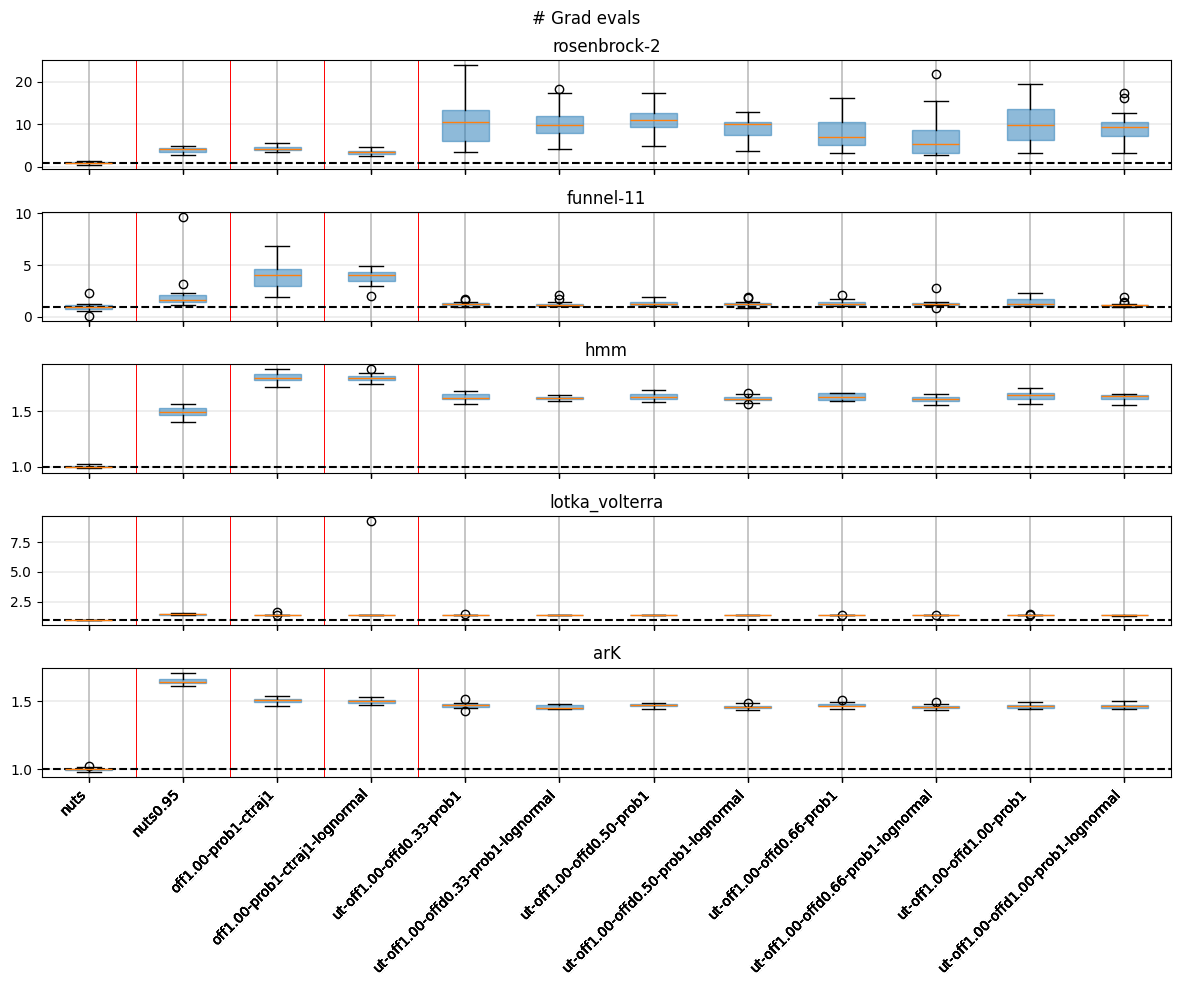

In [425]:
fig, ax = plt.subplots(nexps, 1, figsize=(12, nexps*2.), sharex=True)

for i in range(nexps):
    exp = list(alldata.keys())[i]
    data = alldata[exp]
    
    toplot, toplot2, lbls = [], [], []
    for key in plotkeys:
        toplot.append(data[key][0][:, -1]/data['nuts'][0][:, -1].mean(axis=0))
        lbls.append(key)

    ax[i].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);

    ax[i].set_title(f'{exp}')

for axis in [ax[-1]]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

for axis in ax:
    for i in range(len(plotkeys_baseline)):
        axis.axvline(1.5 + i, color='r', lw=0.7)
    axis.axhline(1, color='k', ls="--")
    axis.grid(which='both', lw=0.3)
    
# ax[0].set_ylim(0, 3)
# ax[0].set_ylabel(r'#Grad/#Grad-NUTS', fontsize=12)
plt.suptitle(f'# Grad evals')
plt.tight_layout()

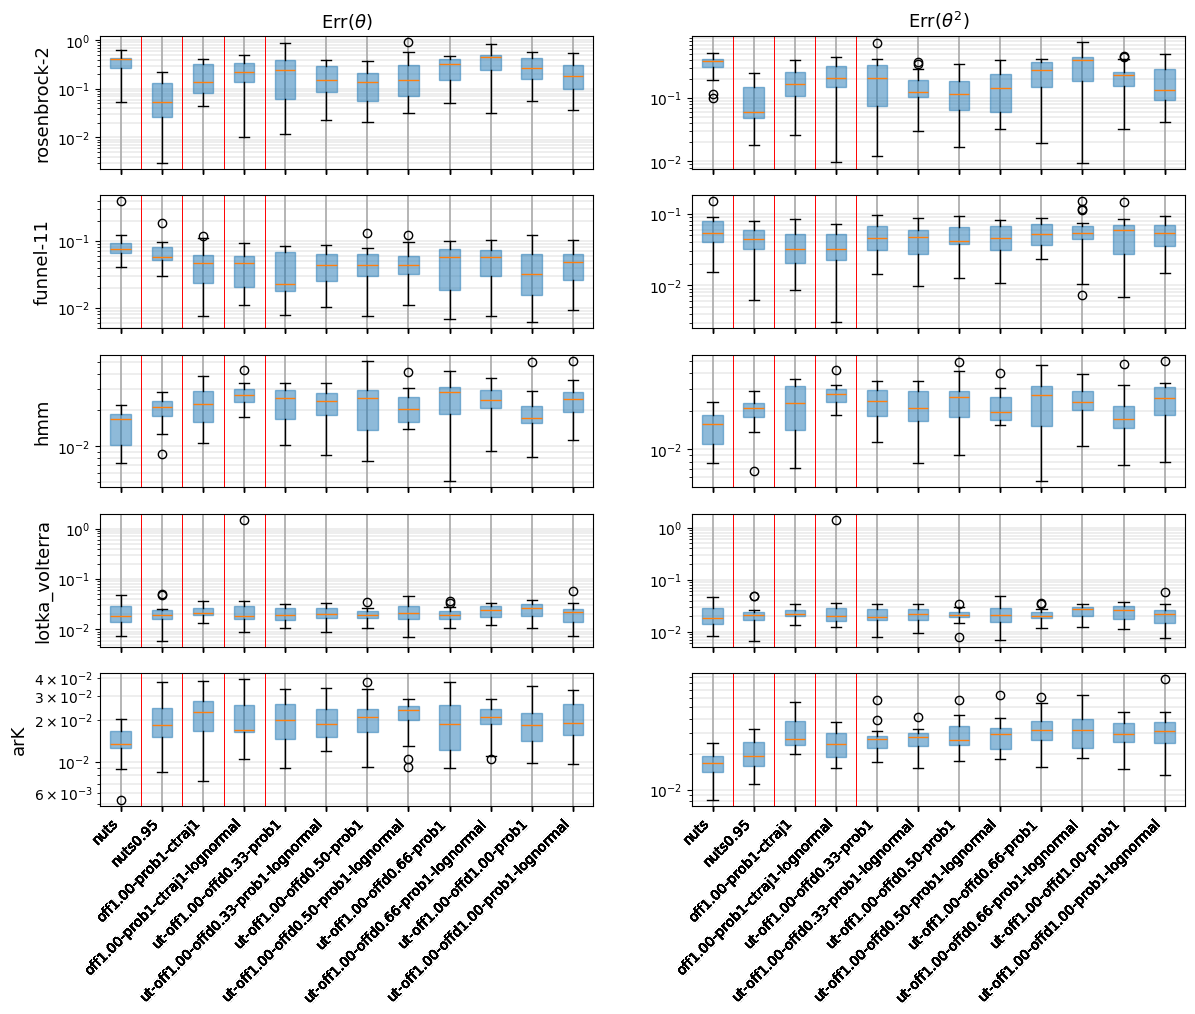

In [426]:
fig, ax = plt.subplots(nexps, 2, figsize=(14, nexps*2), sharex=True)

for i in range(nexps):
    exp = list(alldata.keys())[i]
    data = alldata[exp]

    toplot, toplot2, lbls = [], [], []
    for key in plotkeys:
        # toplot.append([d[-1] for d in data[key][1]])
        # toplot2.append([d[-1] for d in data[key][2]])
        toplot.append(list(data[key][1][:, -1]))
        toplot2.append(list(data[key][2][:, -1]))
        lbls.append(key)

    ax[i, 0].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
    ax[i, 1].boxplot(toplot2, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
    ax[i, 0].set_ylabel(exp, fontsize=13)

for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

ax[0, 0].set_title(r'Err($\theta$)', fontsize=13)
ax[0, 1].set_title(r'Err($\theta^2$)', fontsize=13)
for axis in ax.flatten():
    for i in range(len(plotkeys_baseline)):
        axis.axvline(1.5 + i, color='r', lw=0.7)
    axis.grid(which='both', lw=0.3)
    axis.set_yscale('log')
    


(10.0, 300.0)

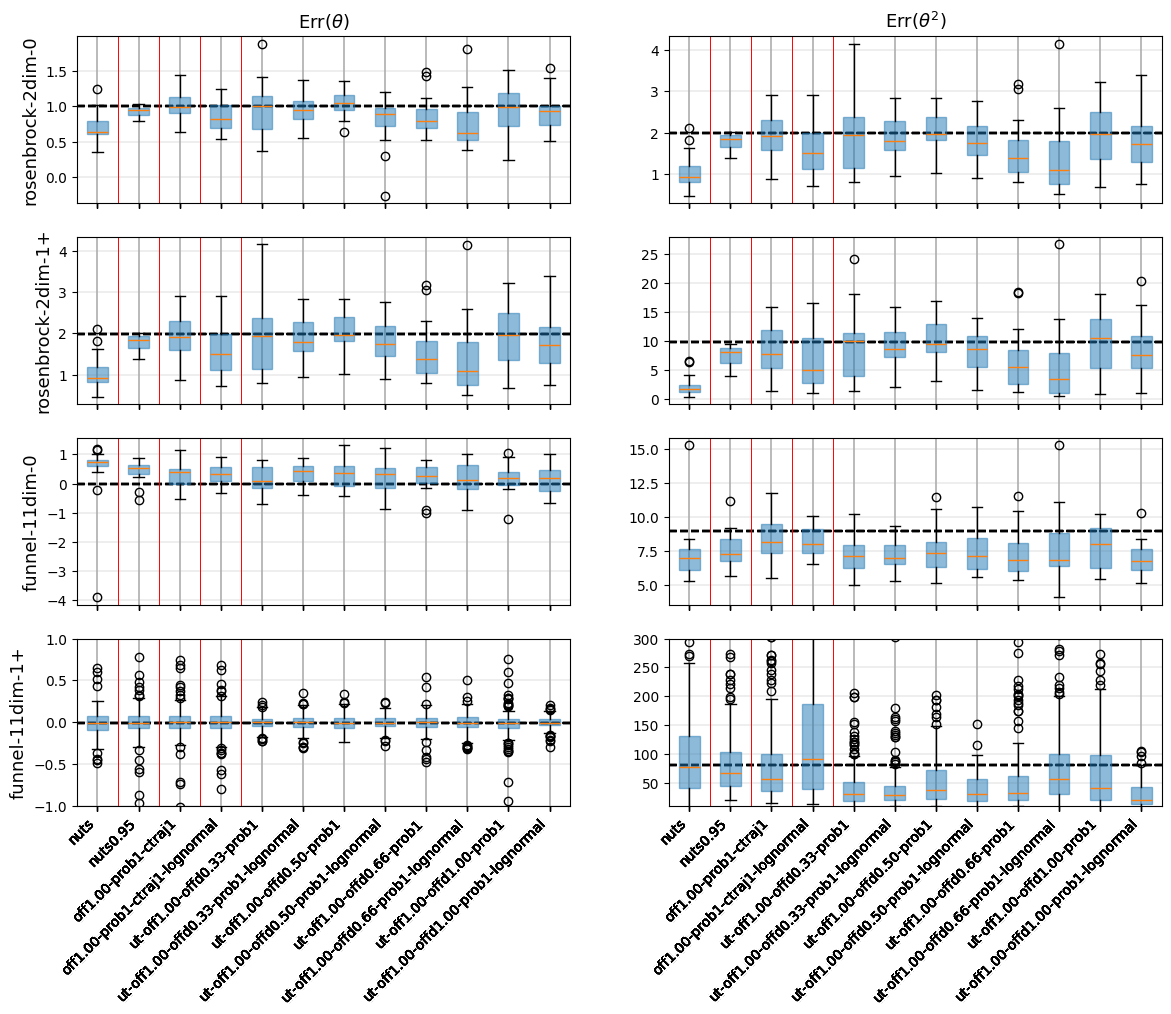

In [427]:
fig, ax = plt.subplots(4, 2, figsize=(14, nexps*2), sharex=True)


for i in range(2):
    for j in range(2):
        exp = ['rosenbrock-2', 'funnel-11'][i]
        data = alldata[exp]
        refs = reference_samples[exp]

        toplot, toplot2, lbls = [], [], []
        for key in plotkeys:
            if j == 0:
                toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
                toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
                ax[2*i+j, 0].axhline(refs[..., 0].mean(), color='k', ls="--");
                ax[2*i+j, 1].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
                ax[2*i+j, 0].set_ylabel(exp + 'dim-0', fontsize=13)

            if j == 1:
                toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
                toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
                ax[2*i+j, 0].axhline(refs[..., 1:].mean(), color='k', ls="--");
                ax[2*i+j, 1].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
                ax[2*i+j, 0].set_ylabel(exp + 'dim-1+', fontsize=13)
            lbls.append(key)
            if 'dist' not in key: ikey += 1 

        ax[2*i+j, 0].boxplot(toplot, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
        ax[2*i+j, 1].boxplot(toplot2, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);

    
for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

ax[0, 0].set_title(r'Err($\theta$)', fontsize=13)
ax[0, 1].set_title(r'Err($\theta^2$)', fontsize=13)
for axis in ax.flatten():
    for i in range(len(plotkeys_baseline)):
        axis.axvline(1.5 + i, color='r', lw=0.7)
    axis.grid(which='both', lw=0.3)
    # axis.set_yscale('log')
ax[-1, 0].set_ylim(-1, 1)    
ax[-1, 1].set_ylim(10, 300)    


## vs non-dr hmc

In [428]:
plotkeys_baseline = ['nuts', 'nuts0.95', 'off1.00-prob1-ctraj1', 'off1.00-prob1-ctraj1-lognormal']
plotkeys = plotkeys_baseline.copy()
for key in allkeys:
    if 'nodr-' in key: plotkeys.append(key)

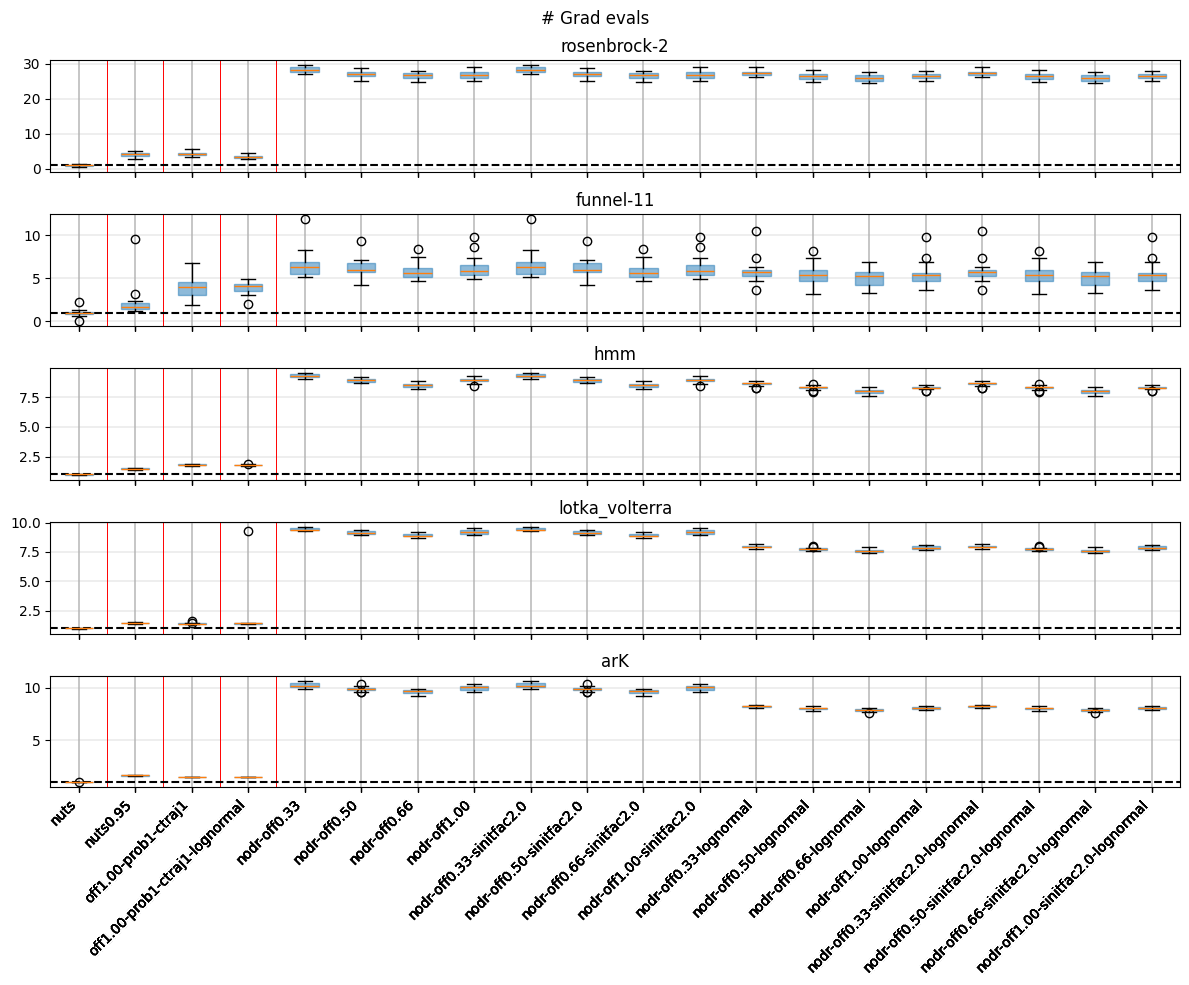

In [429]:
fig, ax = plt.subplots(nexps, 1, figsize=(12, nexps*2.), sharex=True)

for i in range(nexps):
    exp = list(alldata.keys())[i]
    data = alldata[exp]
    
    toplot, toplot2, lbls = [], [], []
    for key in plotkeys:
        toplot.append(data[key][0][:, -1]/data['nuts'][0][:, -1].mean(axis=0))
        lbls.append(key)

    ax[i].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);

    ax[i].set_title(f'{exp}')

for axis in [ax[-1]]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

for axis in ax:
    for i in range(len(plotkeys_baseline)):
        axis.axvline(1.5 + i, color='r', lw=0.7)
    axis.axhline(1, color='k', ls="--")
    axis.grid(which='both', lw=0.3)
    
# ax[0].set_ylim(0, 3)
# ax[0].set_ylabel(r'#Grad/#Grad-NUTS', fontsize=12)
plt.suptitle(f'# Grad evals')
plt.tight_layout()

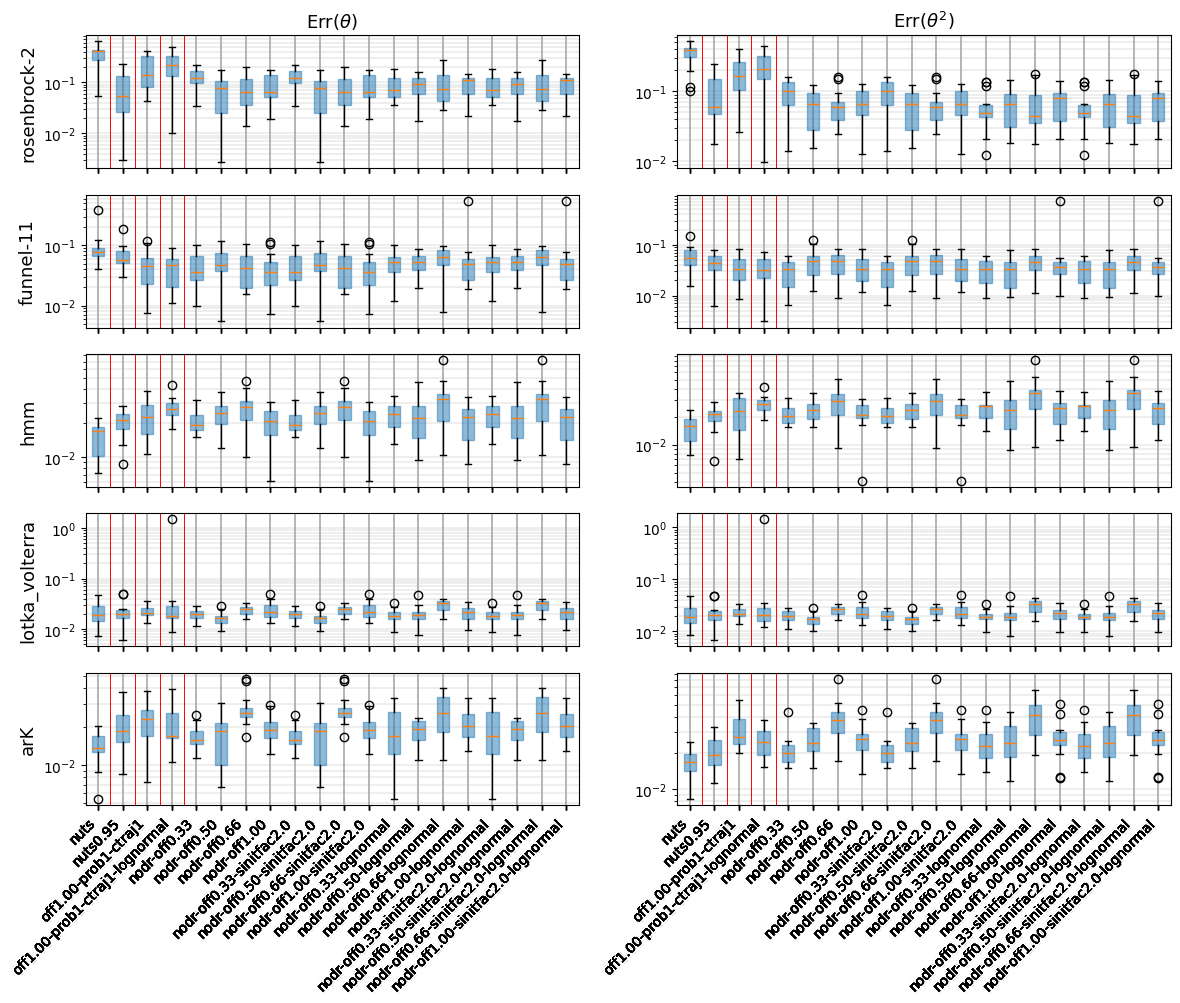

In [430]:
fig, ax = plt.subplots(nexps, 2, figsize=(14, nexps*2), sharex=True)

for i in range(nexps):
    exp = list(alldata.keys())[i]
    data = alldata[exp]

    toplot, toplot2, lbls = [], [], []
    for key in plotkeys:
        # toplot.append([d[-1] for d in data[key][1]])
        # toplot2.append([d[-1] for d in data[key][2]])
        toplot.append(list(data[key][1][:, -1]))
        toplot2.append(list(data[key][2][:, -1]))
        lbls.append(key)

    ax[i, 0].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
    ax[i, 1].boxplot(toplot2, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
    ax[i, 0].set_ylabel(exp, fontsize=13)

for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

ax[0, 0].set_title(r'Err($\theta$)', fontsize=13)
ax[0, 1].set_title(r'Err($\theta^2$)', fontsize=13)
for axis in ax.flatten():
    for i in range(len(plotkeys_baseline)):
        axis.axvline(1.5 + i, color='r', lw=0.7)
    axis.grid(which='both', lw=0.3)
    axis.set_yscale('log')
    
# ax[0].set_ylabel(r'<$\theta$>', fontsize=12)
# ax[1].set_ylabel(r'<$\theta^2$>', fontsize=12)
# plt.suptitle(f'{exp} : RMSE of z-score')
# plt.tight_layout()

(10.0, 300.0)

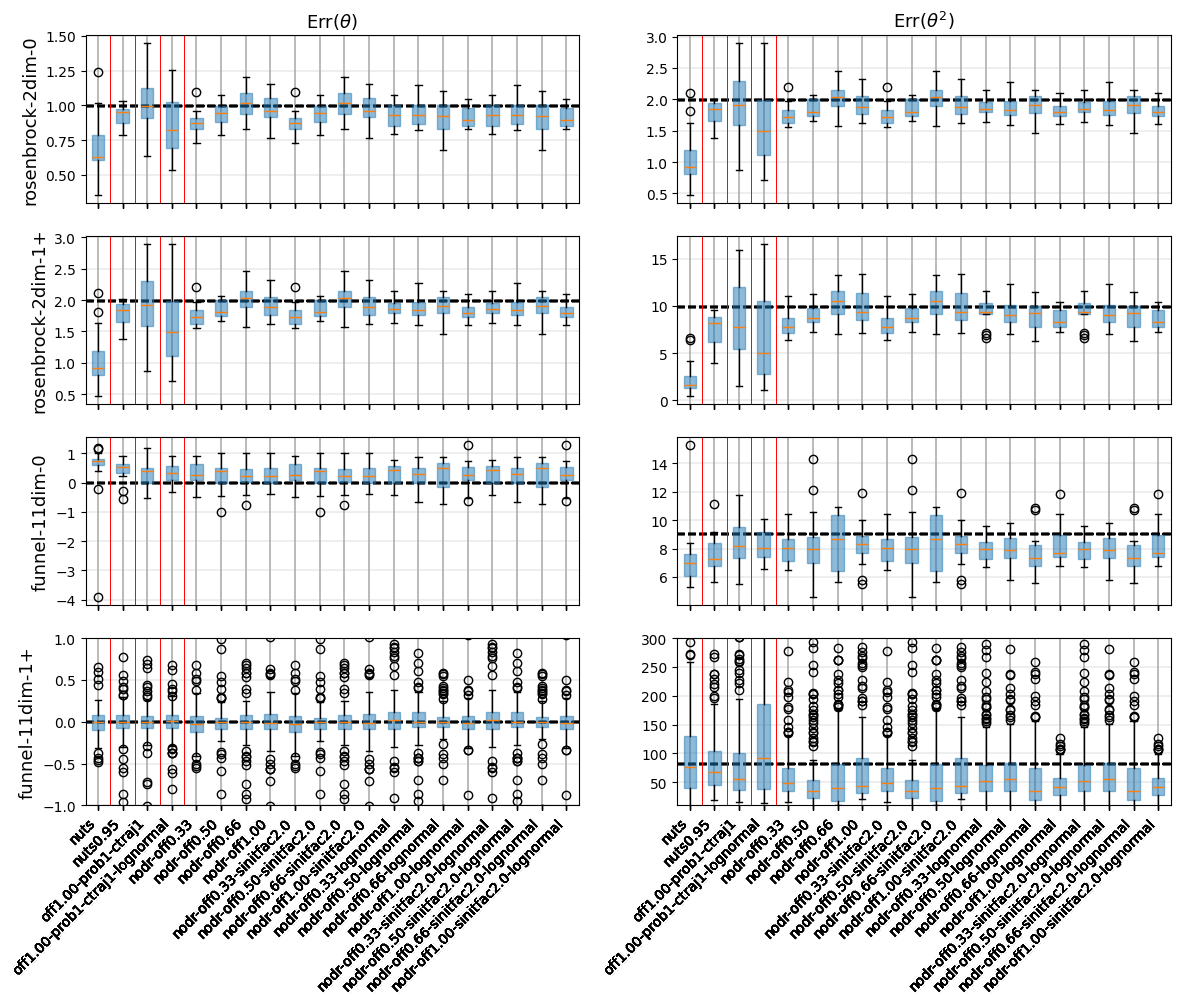

In [431]:
fig, ax = plt.subplots(4, 2, figsize=(14, nexps*2), sharex=True)


for i in range(2):
    for j in range(2):
        exp = ['rosenbrock-2', 'funnel-11'][i]
        data = alldata[exp]
        refs = reference_samples[exp]

        toplot, toplot2, lbls = [], [], []
        for key in plotkeys:
            if j == 0:
                toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
                toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
                ax[2*i+j, 0].axhline(refs[..., 0].mean(), color='k', ls="--");
                ax[2*i+j, 1].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
                ax[2*i+j, 0].set_ylabel(exp + 'dim-0', fontsize=13)

            if j == 1:
                toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
                toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
                ax[2*i+j, 0].axhline(refs[..., 1:].mean(), color='k', ls="--");
                ax[2*i+j, 1].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
                ax[2*i+j, 0].set_ylabel(exp + 'dim-1+', fontsize=13)
            lbls.append(key)
            if 'dist' not in key: ikey += 1 

        ax[2*i+j, 0].boxplot(toplot, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);
        ax[2*i+j, 1].boxplot(toplot2, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls);

    
for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

ax[0, 0].set_title(r'Err($\theta$)', fontsize=13)
ax[0, 1].set_title(r'Err($\theta^2$)', fontsize=13)
for axis in ax.flatten():
    for i in range(len(plotkeys_baseline)):
        axis.axvline(1.5 + i, color='r', lw=0.7)
    axis.grid(which='both', lw=0.3)
    # axis.set_yscale('log')
ax[-1, 0].set_ylim(-1, 1)    
ax[-1, 1].set_ylim(10, 300)    


# Images

In [423]:
# Image('/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//compare_stepadapt/target0.80-beta/hist.png')
Image('/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-uturn/offset0.33-prob1/hist.png')
# Image('/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-prob1/hist.png')


FileNotFoundError: No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-uturn/offset0.33-prob1/hist.png'

FileNotFoundError: No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-uturn/offset0.33-prob1/hist.png'

<IPython.core.display.Image object>

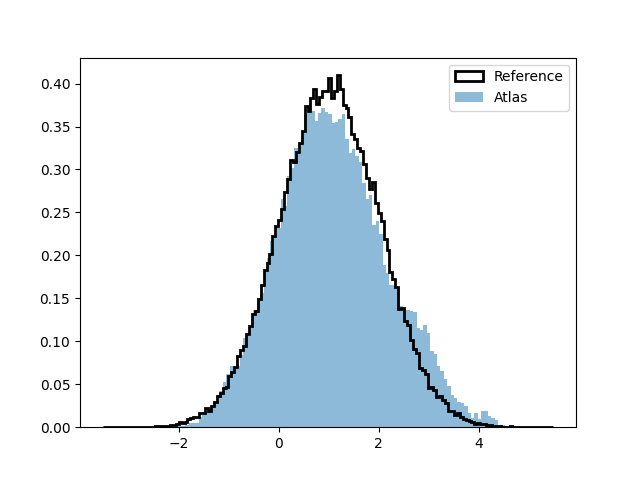

In [185]:
Image('/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//compare_stepadapt/target0.80-lognormal//hist.png')

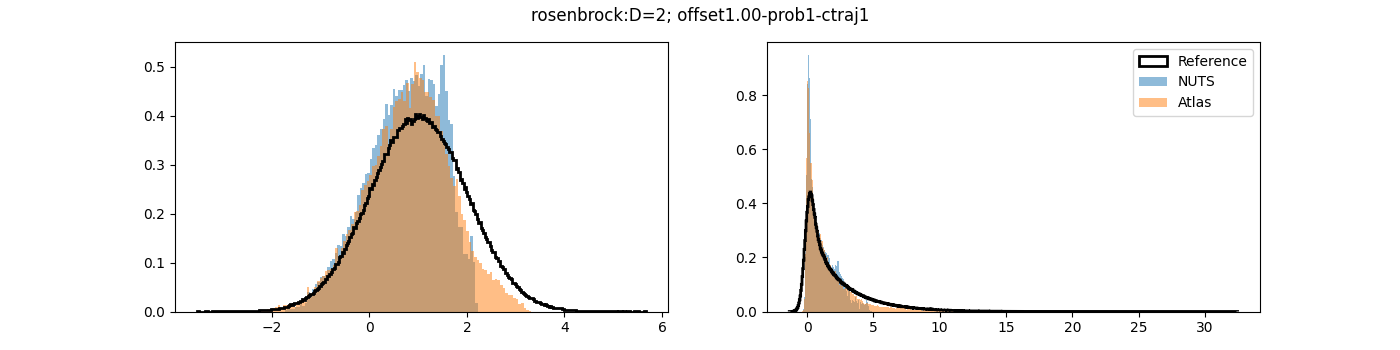

In [203]:
Image('/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset1.00-prob1-ctraj1//hist.png')

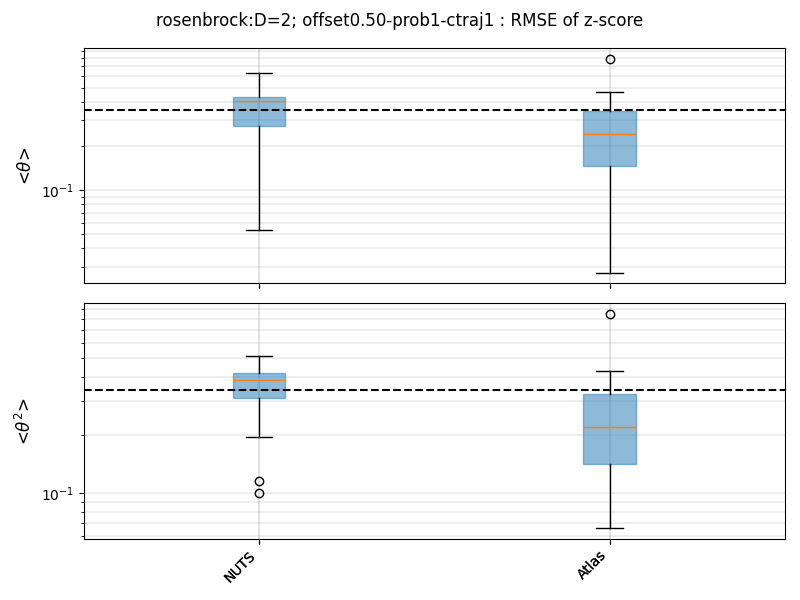

In [193]:
Image('/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset0.50-prob1-ctraj1/rmse.png')

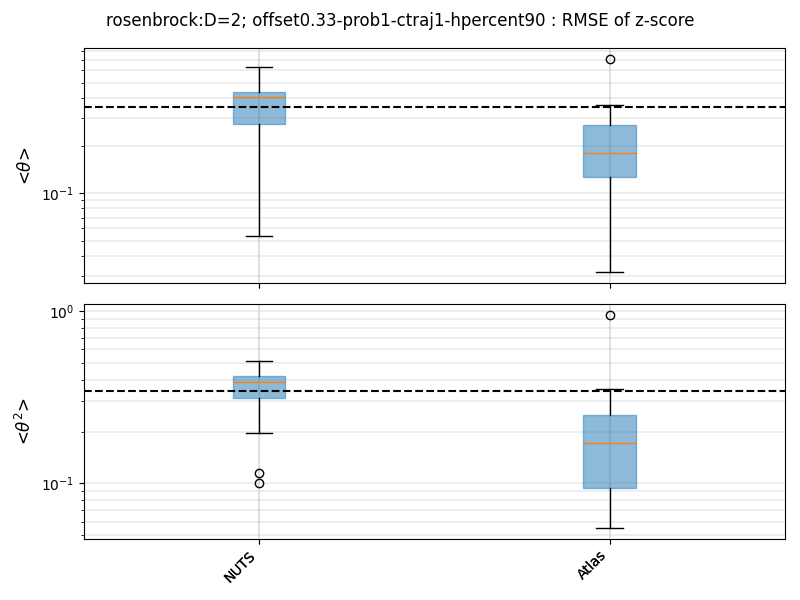

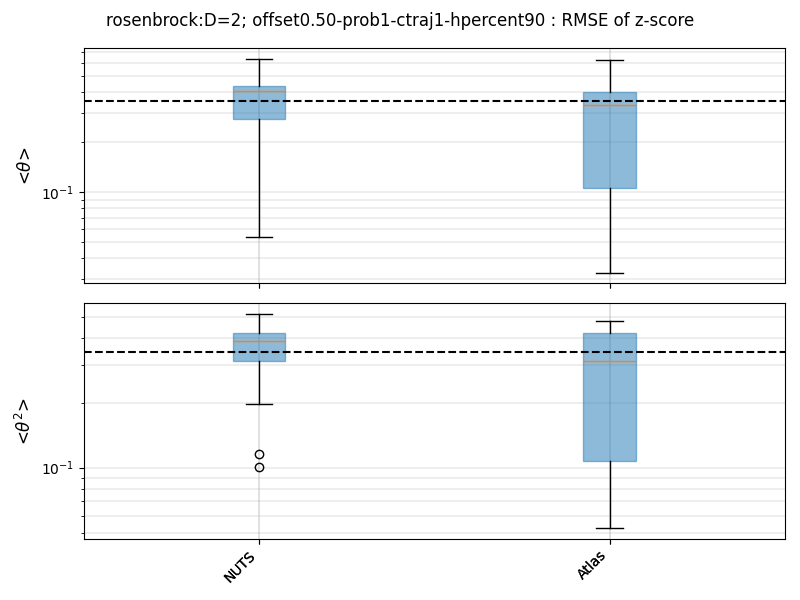

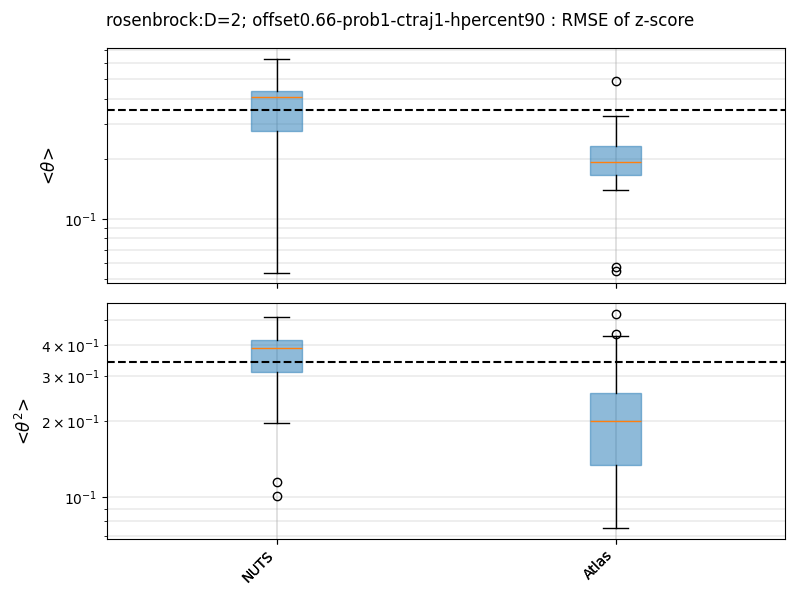

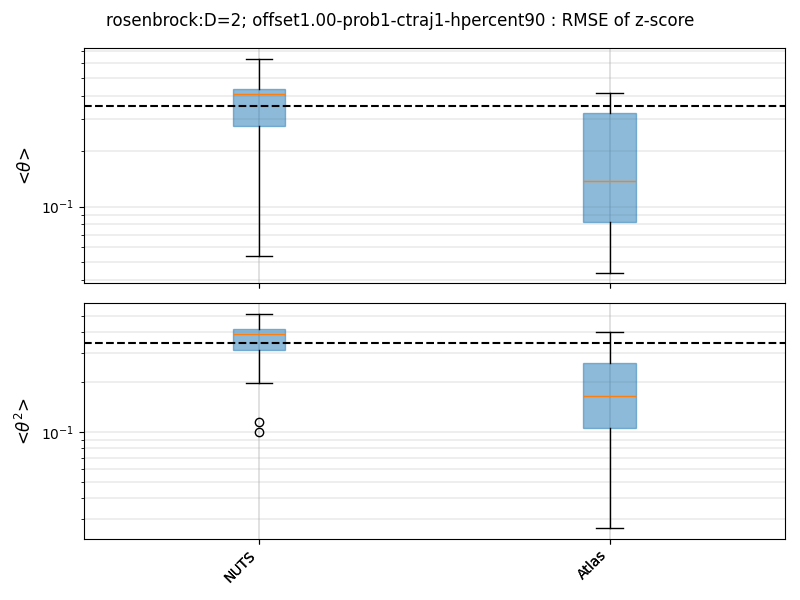

In [236]:
for off in [0.33, 0.5, 0.66, 1.0]:
    display(Image(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-hpercent90/rmse.png'))
    

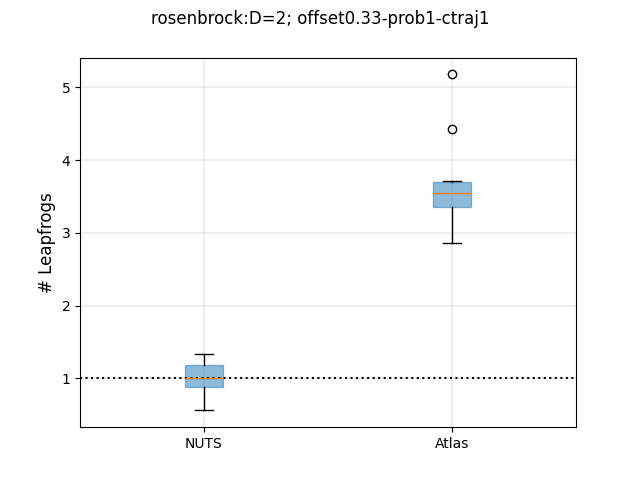

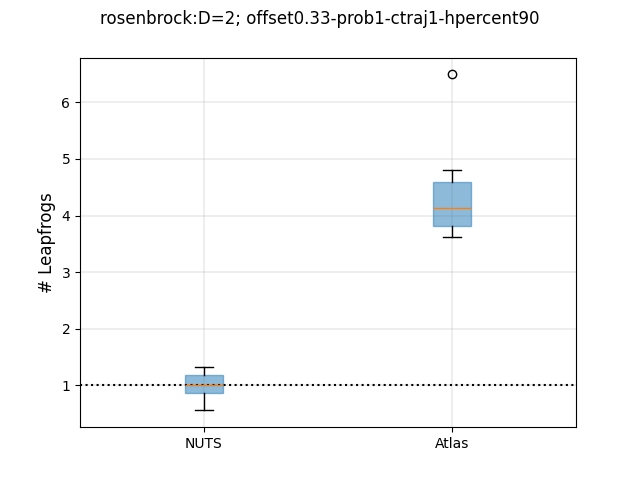

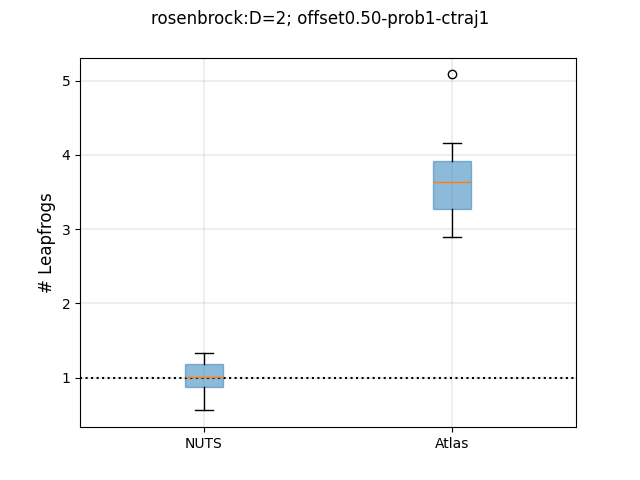

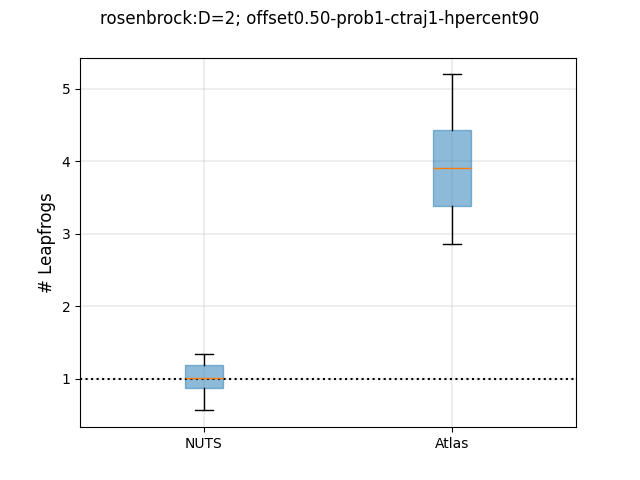

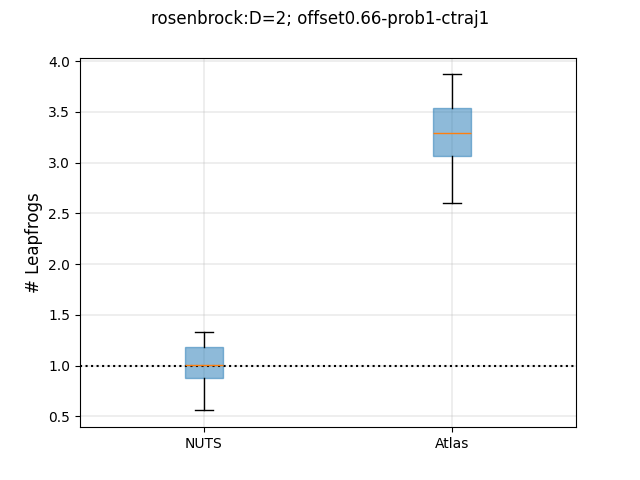

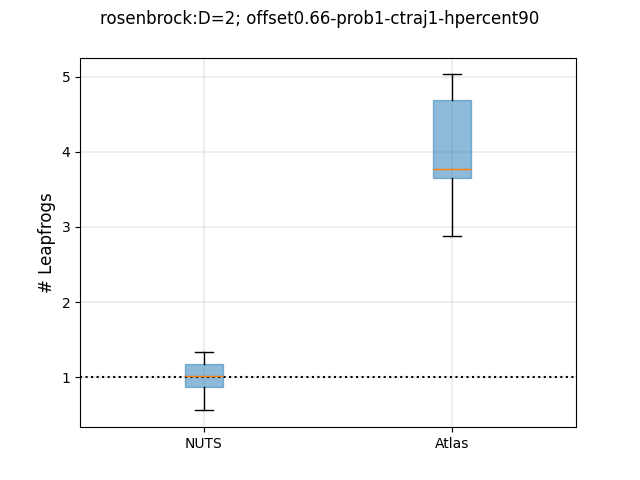

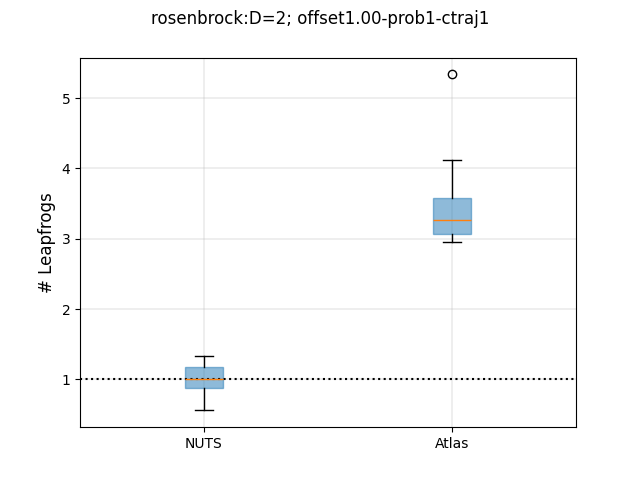

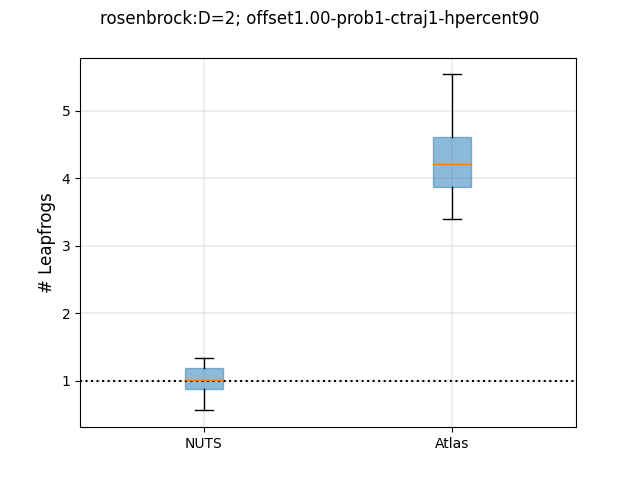

In [239]:
for off in [0.33, 0.5, 0.66, 1.0]:
    display(Image(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/gradcounts.png'))
    display(Image(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-hpercent90/gradcounts.png'))
    

In [231]:
# exp = 'funnel-11'
# # exp = 'rosenbrock-2'
# for off in [0.33, 0.5, 0.66, 1.0]:
#     # display(Image(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-nlbfgs5/hist.png'))
#     display(Image(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/hist.png'))
#     display(Image(f'/mnt/ceph/users/cmodi/adaptive_hmc//{exp}/adaptive2re/offset{off:0.2f}-ctraj1-prob1/hist.png'))
    

In [10]:
# !ls /mnt/ceph/users/cmodi/adaptive_hmc/rosenbrock-2/

0.33
(16, 5001) 4213485 1.0
(16, 5001) 3698023 0.8776637391612881


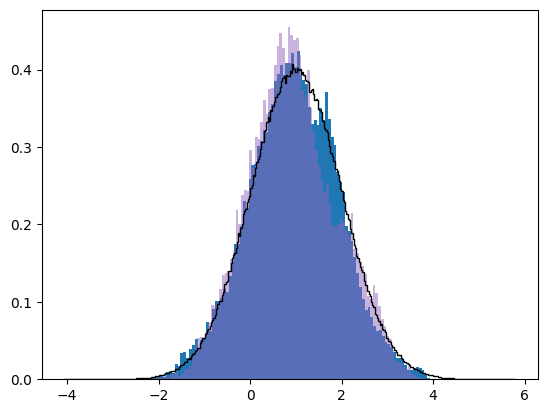

0.5
(16, 5001) 3819220 1.0
(16, 5001) 3337815 0.8739520111436366


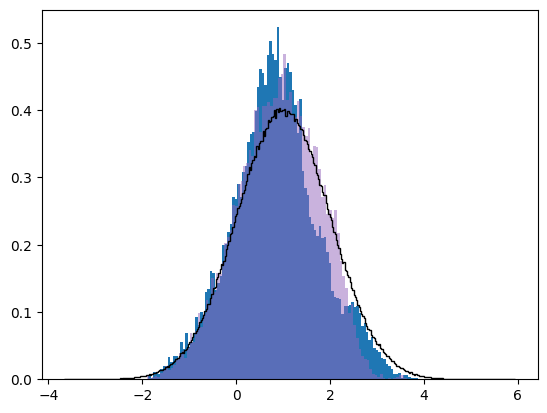

0.66
(16, 5001) 3926196 1.0
(16, 5001) 3284431 0.83654280122541


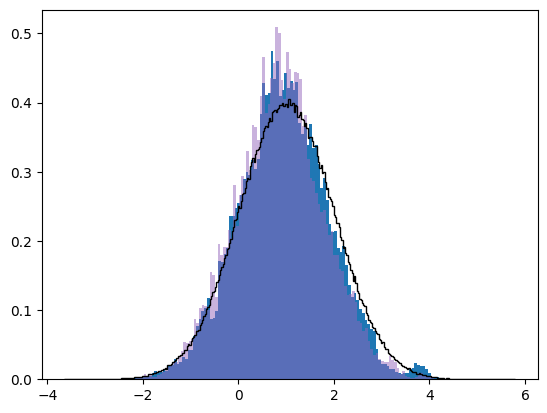

1.0
(16, 5001) 4175780 1.0
(16, 5001) 3441641 0.8241911690749991


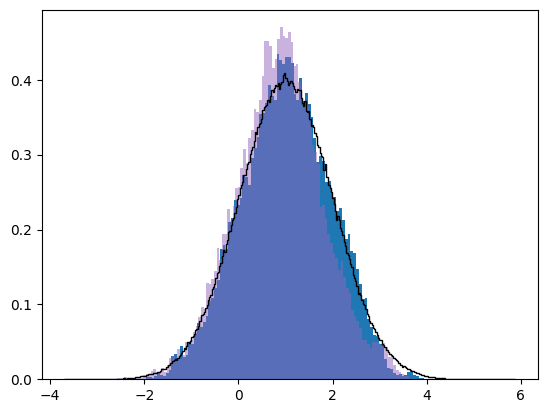

In [91]:
# exp = 'funnel-11'
exp = 'rosenbrock-2'
# for off in [0.33, 0.5, 0.66, 1.0]:
#     # s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/samples-{i}.npy') for i in range(16)])
#     # plt.hist(np.random.normal(0, 3, 1000000), density=True, bins='auto', histtype='step', color='k')
#     s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/samples-{i}.npy') for i in range(16)])
#     plt.hist(s[..., 0].flatten(), density=True, bins='auto')
#     # s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-nleapadapt200/samples-{i}.npy') for i in range(16)])
#     # plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
#     s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-hpercent75/samples-{i}.npy') for i in range(16)])
#     plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
#     s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-hpercent90/samples-{i}.npy') for i in range(16)])
#     plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
#     # s = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/adaptive2re/offset{off:0.2f}-ctraj2-prob1/samples-{i}.npy') for i in range(16)])
#     # plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
#     plt.show()
    
    
for off in [0.33, 0.5, 0.66, 1.0]:
    print(off)
    plt.hist(np.random.normal(1, 1, 1000000), density=True, bins='auto', histtype='step', color='k')
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', color='C0')
        g0 = g.sum()
        print(g.shape, g.sum(), g.sum()/g0)
    except: pass
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-lognormal/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-lognormal/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', color='C4', alpha=0.5)
        print(g.shape, g.sum(), g.sum()/g0)
    except: pass
    # try:
    #     s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-uturn/offset{off:0.2f}-prob1/samples-{i}.npy') for i in range(16)])
    #     g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-uturn/offset{off:0.2f}-prob1/gradcounts-{i}.npy') for i in range(16)])
    #     plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7, color='C1')
    #     print(g.shape, g.sum(), g.sum()/g0)
    # except: pass
    # try:
    #     s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-hmc/offset{off:0.2f}-prob1/samples-{i}.npy') for i in range(16)])
    #     g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-hmc/offset{off:0.2f}-prob1/gradcounts-{i}.npy') for i in range(16)])
    #     plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7, color='C2')
    #     print(g.shape, g.sum(), g.sum()/g0)
    # except Exception as e: 
    #     print(e)
# s = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/adaptive2re/offset{off:0.2f}-ctraj2-prob1/samples-{i}.npy') for i in range(16)])
    # plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
    plt.show()

0.33
(16, 5001) 7506222
(16, 5001) 3963768 0.5280643178419183
(16, 5001) 18739483 2.496526614853651


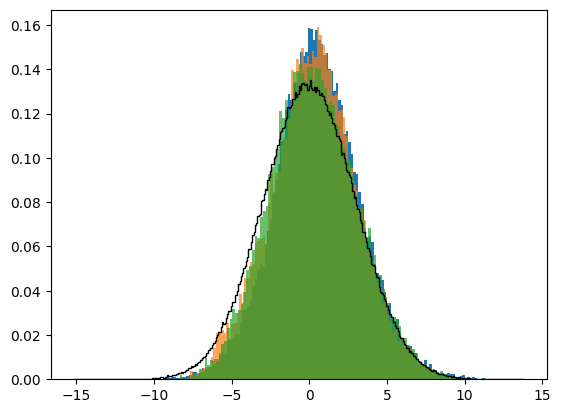

0.5
(16, 5001) 9030306
(16, 5001) 3747246 0.4149633467570202
(16, 5001) 17340714 1.9202797778945697


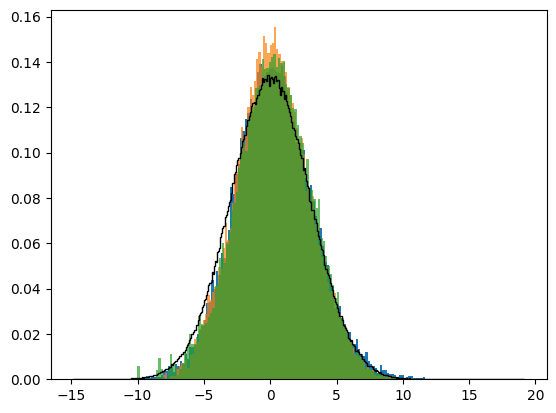

0.66
(16, 5001) 8557228
(16, 5001) 4012457 0.46889682032546054
(16, 5001) 16459831 1.923500343802923


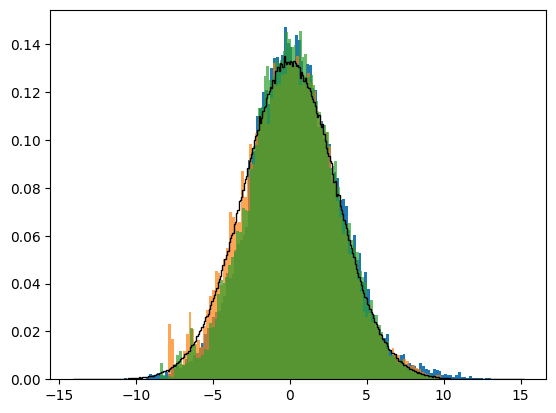

1.0
(16, 5001) 9017895
(16, 5001) 17618333 1.9537079329488756


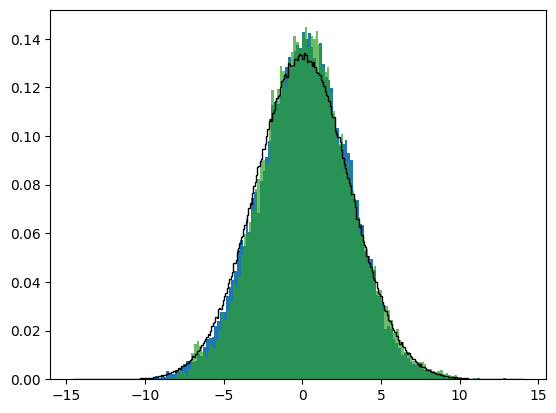

In [84]:
exp = 'funnel-11'
for off in [0.33, 0.5, 0.66, 1.0]:
    print(off)
    plt.hist(np.random.normal(0, 3, 1000000), density=True, bins='auto', histtype='step', color='k')
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', color='C0')
        print(g.shape, g.sum())
        g0 = g.sum()
    except: pass
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-uturn/offset{off:0.2f}-prob1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-uturn/offset{off:0.2f}-prob1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7, color='C1')
        print(g.shape, g.sum(), g.sum()/g0)
    except: pass
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-hmc/offset{off:0.2f}-prob1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-hmc/offset{off:0.2f}-prob1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7, color='C2')
        print(g.shape, g.sum(), g.sum()/g0)
    except Exception as e: 
        print(e)
# s = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/adaptive2re/offset{off:0.2f}-ctraj2-prob1/samples-{i}.npy') for i in range(16)])
    # plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
    plt.show()

0.33
(16, 5001) 11085531
(16, 5001) 3963768 0.3575623035107655
(16, 5001) 18739483 1.6904452299127575


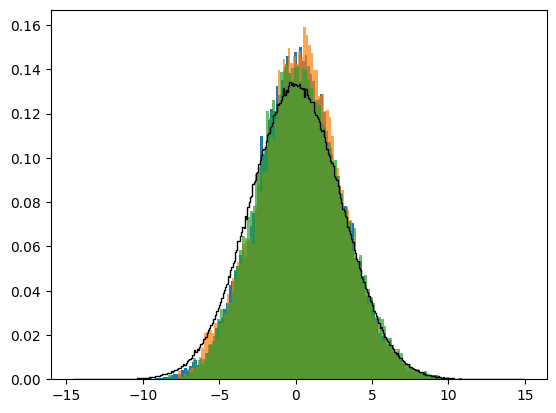

0.5
(16, 5001) 10883688
(16, 5001) 3747246 0.34429928531578635
(16, 5001) 17340714 1.5932755514491044


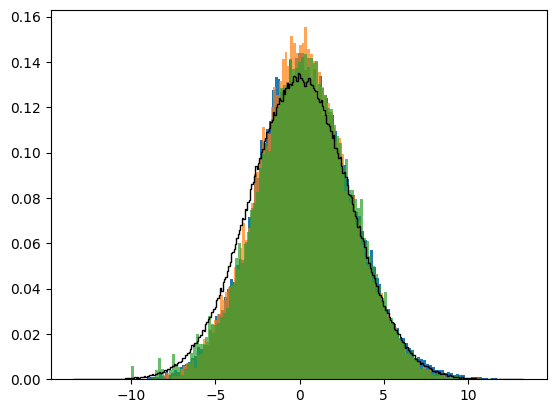

0.66
(16, 5001) 13569488
(16, 5001) 4012457 0.29569700787531555
(16, 5001) 16459831 1.213003099306326


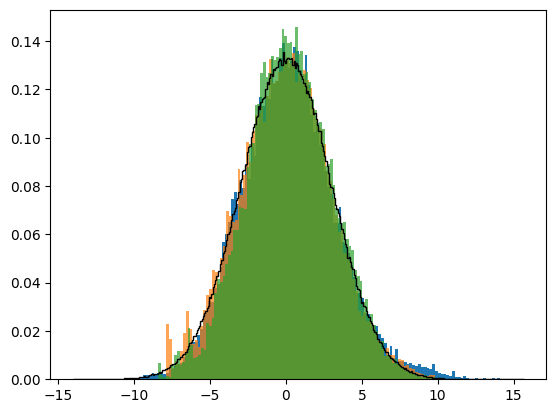

1.0
(16, 5001) 11147239
(16, 5001) 17618333 1.580510922928987


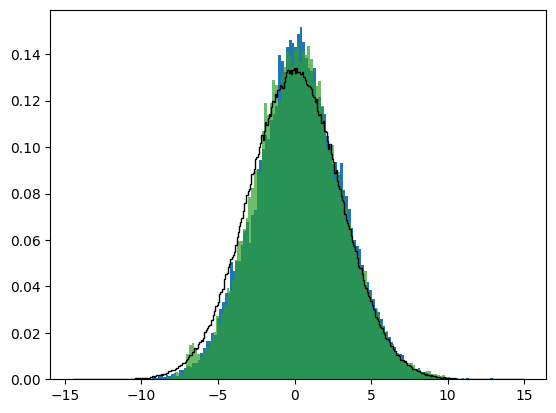

In [94]:
exp = 'funnel-11'
for off in [0.33, 0.5, 0.66, 1.0]:
    print(off)
    plt.hist(np.random.normal(0, 3, 1000000), density=True, bins='auto', histtype='step', color='k')
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', color='C0')
        print(g.shape, g.sum())
        g0 = g.sum()
    except: pass
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-uturn/offset{off:0.2f}-prob1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-uturn/offset{off:0.2f}-prob1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7, color='C1')
        print(g.shape, g.sum(), g.sum()/g0)
    except: pass
    try:
        s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-hmc/offset{off:0.2f}-prob1/samples-{i}.npy') for i in range(16)])
        g = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-hmc/offset{off:0.2f}-prob1/gradcounts-{i}.npy') for i in range(16)])
        plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7, color='C2')
        print(g.shape, g.sum(), g.sum()/g0)
    except Exception as e: 
        print(e)
# s = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/adaptive2re/offset{off:0.2f}-ctraj2-prob1/samples-{i}.npy') for i in range(16)])
    # plt.hist(s[..., 0].flatten(), density=True, bins='auto', alpha=0.7)
    plt.show()

In [99]:
s[..., 1:].mean(axis=1).flatten(), (s[..., 1:]**2).mean(axis=1).flatten()

(array([-2.19364331e-02, -6.23630005e-02, -2.01490528e-02,  1.07677612e-01,
        -4.46085023e-02,  1.36625744e-01, -7.73010514e-03, -7.47579713e-02,
        -2.04398083e-02, -2.50886704e-02, -5.63747061e-01, -2.85234788e-01,
         1.88876546e-01, -7.06267831e-01, -1.48822296e-02,  5.52657350e-01,
        -4.47516169e-01,  1.08054297e-01,  2.64420658e-01, -1.67725369e-03,
        -2.61823475e-01, -1.79848002e-01, -1.94424649e-01,  2.45621824e-02,
        -1.21105134e-01, -6.43525428e-02, -1.04551162e-01,  5.47238425e-02,
         5.12899332e-02, -5.75539550e-02, -1.97113819e-01,  1.53220120e-01,
         3.25197626e-03,  6.70294310e-03,  1.09069211e-01, -1.13308778e-01,
         7.90004043e-02, -1.50074879e-01,  1.23118914e-01, -5.35520473e-02,
         4.97101703e-02, -1.46149286e-01, -9.50868411e-03,  9.58731806e-02,
        -5.92670814e-02,  2.43700189e-02,  5.08972519e-02,  3.86745497e-02,
        -2.01718386e-01, -3.14103344e-03,  1.00971117e-02,  1.34963721e-01,
        -3.5

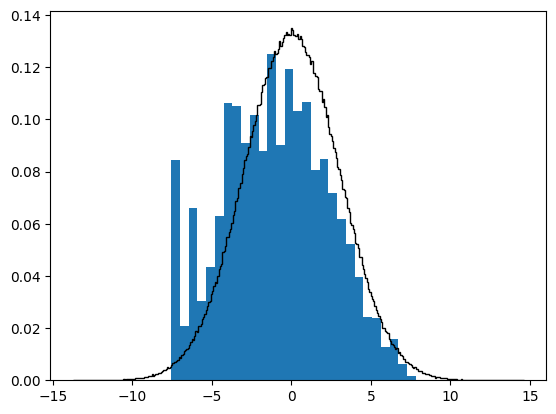

In [70]:
s = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-hmc/offset0.50-prob1/samples_constrained-4.npy')
plt.hist(s[..., 0], density=True, bins='auto');
plt.hist(np.random.normal(0, 3, 1000000), density=True, bins='auto', histtype='step', color='k');


(909071, 466938, 197903)

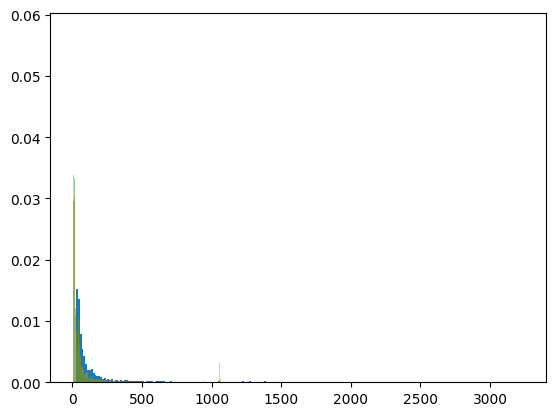

In [69]:
g = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-hmc/offset0.50-prob1/gradcounts-4.npy')
g2 = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset0.50-prob1-ctraj1//gradcounts-4.npy')
g3 = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-uturn/offset0.50-prob1//gradcounts-4.npy')
plt.hist(g, density=True, bins='auto');
plt.hist(g2, density=True, bins='auto', alpha=0.5);
plt.hist(g3, density=True, bins='auto', alpha=0.5);
g.sum(), g2.sum(), g3.sum()

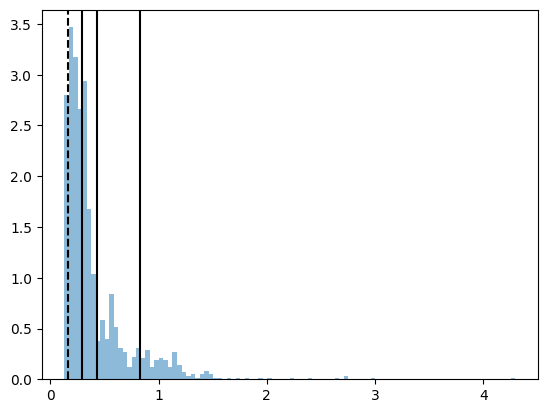

In [269]:
exp = 'rosenbrock-2'
# t = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/trajectories-{i}.npy') for i in range(1)])
# plt.hist(t.flatten(), density=True, bins=100);
t = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-hpercent90/trajectories-{i}.npy') for i in range(1)])
plt.hist(t.flatten(), density=True, bins=100, alpha=0.5);
plt.axvline(np.percentile(t, 10), color='k', ls='--')
plt.axvline(np.percentile(t, 50), color='k')
plt.axvline(np.percentile(t, 75), color='k')
plt.axvline(np.percentile(t, 90), color='k')

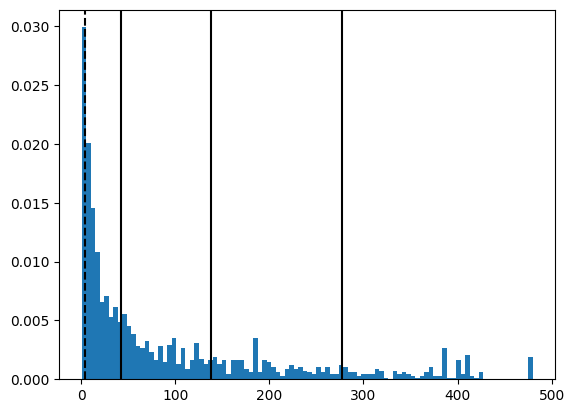

In [268]:
exp = 'funnel-11'
t = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1/trajectories-{i}.npy') for i in range(1)])
plt.hist(t.flatten(), density=True, bins=100);
# t = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset{off:0.2f}-prob1-ctraj1-hpercent90/trajectories-{i}.npy') for i in range(1)])
# plt.hist(t.flatten(), density=True, bins=100, alpha=0.5);
plt.axvline(np.percentile(t, 10), color='k', ls='--')
plt.axvline(np.percentile(t, 50), color='k')
plt.axvline(np.percentile(t, 75), color='k')
plt.axvline(np.percentile(t, 90), color='k')

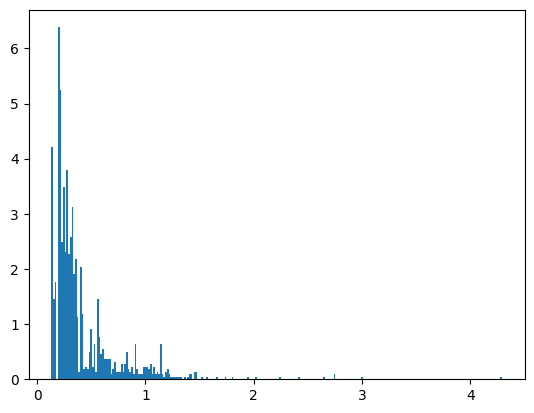

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
np.inf - np.inf

nan

In [96]:
tmp = {
  "I": 20,
  "J": 100,
  "y": [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  ]
}


In [321]:
tmpy = {}
j = 10
tmpy["y"] = np.array(tmp['y'])[:, :j].tolist()
tmpy["I"] = tmp["I"]
tmpy["J"] = j
print(tmpy)


{'y': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 0, 1, 1, 0, 1], [0, 0, 1, 0, 0, 1, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1, 0, 1, 1, 1], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1], [0, 1, 0, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1], [1, 1, 1, 0, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 1, 0, 1], [1, 1, 1, 0, 1, 0, 0, 1, 1, 1], [0, 1, 1, 1, 0, 0, 1, 1, 1, 1], [0, 1, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 0, 0, 0, 1, 0, 0, 1, 0]], 'I': 20, 'J': 10}


In [322]:
# import json
# with open('/mnt/ceph/users/cmodi/PosteriorDB/irt_2pl_mini2/irt_2pl_mini.data.json', 'w', ) as fp:
#     json.dump(tmpy, fp)

In [357]:
s1 = np.load('/mnt/ceph/users/cmodi/PosteriorDB/irt_2pl_mini2/samples.npy')
s2 = np.load('/mnt/ceph/users/cmodi/PosteriorDB/irt_2pl_mini/samples.npy')
sfull = np.load('/mnt/ceph/users/cmodi/PosteriorDB/irt_2pl/samples.npy')

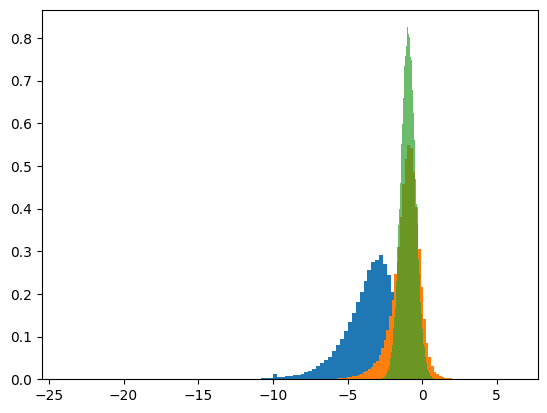

In [358]:
i = 50 
plt.hist(s1[..., i].flatten(), density=True, bins=100);
plt.hist(s2[..., i].flatten(), density=True, bins=100);
plt.hist(sfull[..., i].flatten(), density=True, bins=100, alpha=0.7);
# plt.yscale('log')

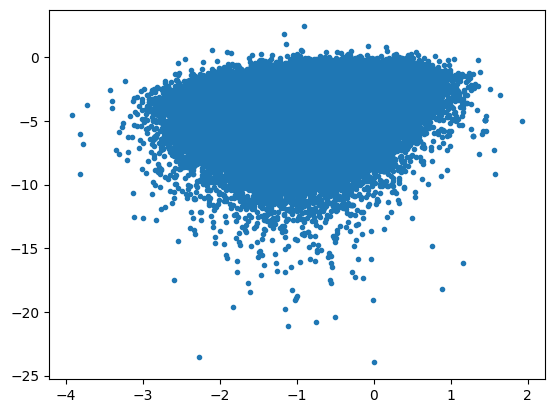

In [359]:
i, j = 0, 50 
plt.plot(s1[..., i].flatten(), s1[..., j].flatten(), '.')
# plt.plot(s2[..., i].flatten(), s2[..., j].flatten(), '.')
# plt.hist(s2[..., i].flatten(), density=True, bins=100, alpha=0.7);
# plt.yscale('log')

In [108]:
s1.shape, s9.shape, sfull.shape;

In [372]:
s9 = np.load('/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini2/nuts/target0.95/samples.npy')[:, :5000]
g9 = np.load('/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini2/nuts/target0.95/leapfrogs.npy')[:, :5000]
count, err91 = dg.cumulative_rmse_per_chain(s9, counts=g9, ref_samples=s1, mode=1, relative='scatter')
count, err92 = dg.cumulative_rmse_per_chain(s9, counts=g9, ref_samples=s1, mode=2, relative='scatter')

s8 = np.load('/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini2/nuts/target0.80//samples.npy')[:, :5000]
g8 = np.load('/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini2/nuts/target0.80/leapfrogs.npy')[:, :5000]
count, err81 = dg.cumulative_rmse_per_chain(s8, counts=g8, ref_samples=s1, mode=1, relative='scatter')
count, err82 = dg.cumulative_rmse_per_chain(s8, counts=g8, ref_samples=s1, mode=2, relative='scatter')

# s82 = np.load('/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini/nuts/target0.80//samples.npy')[:, :5000]
# g82 = np.load('/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini/nuts/target0.80/leapfrogs.npy')[:, :5000]
# count, err821 = dg.cumulative_rmse_per_chain(s82, counts=g82, ref_samples=s1, mode=1, relative='scatter')
# count, err822 = dg.cumulative_rmse_per_chain(s82, counts=g82, ref_samples=s1, mode=2, relative='scatter')


[(-298, 207), (-24, 7864), (-23, 48), (-21, 608), (-14, 3351), (-13, 2), (-12, 599), (-11, 11684), (-1, 54156), (1, 76266), (2, 4617), (3, 630)]
[(-298, 373), (-24, 8199), (-23, 60), (-21, 766), (-14, 5957), (-13, 2), (-12, 1580), (-11, 7550), (-1, 53942), (1, 75818), (2, 5149), (3, 636)]
(32, 5000, 53) (32, 5001, 53)


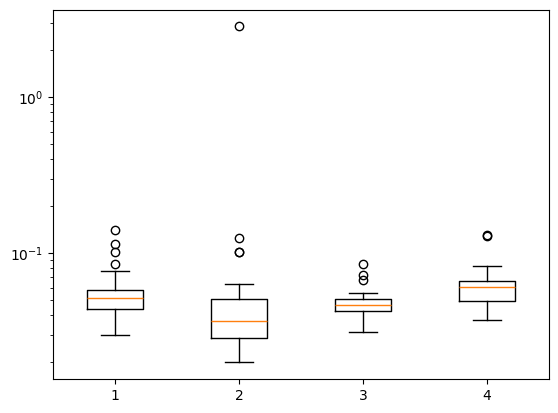

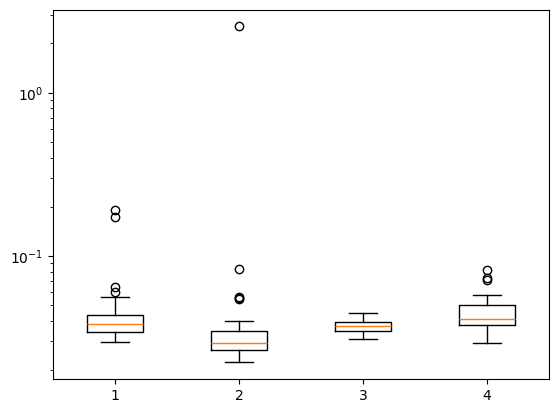

In [439]:

filename = '/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini2/atlasv2-nuts/offset1.00-prob1-ctraj2//'
sa = np.stack([np.load(f'{filename}/samples_constrained-{i}.npy') for i in range(32)])
ga = np.stack([np.load(f'{filename}//gradcounts-{i}.npy') for i in range(32)])
ta = np.stack([np.load(f'{filename}//trajectories-{i}.npy') for i in range(32)])
count, erra1 = dg.cumulative_rmse_per_chain(sa, counts=ga, ref_samples=s1, mode=1, relative='scatter')
count, erra2 = dg.cumulative_rmse_per_chain(sa, counts=ga, ref_samples=s1, mode=2, relative='scatter')
a = np.stack([np.load(f'{filename}/accepts-{i}.npy') for i in range(32)])
print(list(zip(*np.unique(a, return_counts=True))))


filename = '/mnt/ceph/users/cmodi/atlassampler/irt_2pl_mini2/atlasv2-nuts/offset1.00-prob1-ctraj1/'
sa2 = np.stack([np.load(f'{filename}/samples_constrained-{i}.npy') for i in range(32)])
ga2 = np.stack([np.load(f'{filename}//gradcounts-{i}.npy') for i in range(32)])
count, erra21 = dg.cumulative_rmse_per_chain(sa2, counts=ga2, ref_samples=s1, mode=1, relative='scatter')
count, erra22 = dg.cumulative_rmse_per_chain(sa2, counts=ga2, ref_samples=s1, mode=2, relative='scatter')
a2 = np.stack([np.load(f'{filename}/accepts-{i}.npy') for i in range(32)])
print(list(zip(*np.unique(a2, return_counts=True))))
    
print(s8.shape, sa.shape)
plt.boxplot([err81[...,-1],  err91[...,-1], erra1[...,-1], erra21[...,-1]], showfliers=True);
plt.yscale('log')
plt.show()
plt.boxplot([err82[...,-1],  err92[...,-1], erra2[...,-1], erra22[...,-1]], showfliers=True);
plt.yscale('log')
plt.show()


In [440]:
ga.sum(axis=0)

array([2970, 1838, 2013, ..., 3917, 2289, 2182])

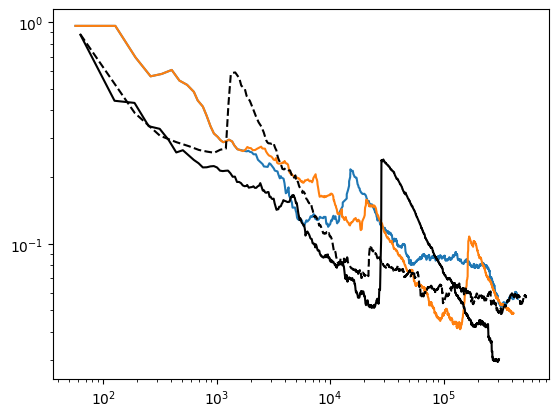

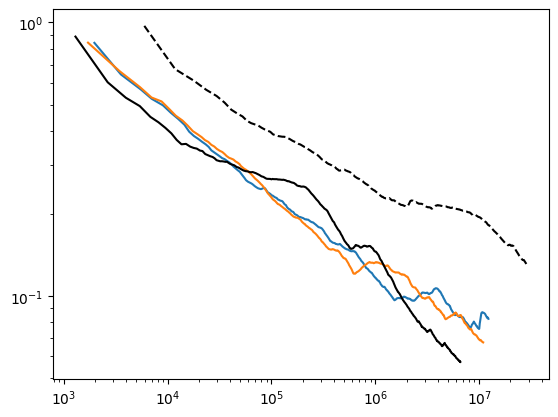

In [436]:
i = 22
plt.plot(np.cumsum(ga[i]), erra1[i])
plt.plot(np.cumsum(ga2[i]), erra21[i])
plt.plot(np.cumsum(g8[i]), err81[i], 'k')
plt.plot(np.cumsum(g9[i]), err91[i], 'k--')
plt.loglog()
plt.show()

plt.plot(np.cumsum(ga.sum(axis=0)), erra1.mean(axis=0))
plt.plot(np.cumsum(ga2.sum(axis=0)), erra21.mean(axis=0))
plt.plot(np.cumsum(g8.sum(axis=0)), err81.mean(axis=0), 'k')
plt.plot(np.cumsum(g9.sum(axis=0)), err91.mean(axis=0), 'k--')
plt.loglog()
plt.show()

# plt.plot(np.cumsum(ga.sum(axis=0)), (erra1**2).mean(axis=0))
# plt.plot(np.cumsum(ga2.sum(axis=0)), (erra21**2).mean(axis=0))
# plt.plot(np.cumsum(g8.sum(axis=0)), (err81**2).mean(axis=0), 'k')
# plt.plot(np.cumsum(g9.sum(axis=0)), (err91**2).mean(axis=0), 'k--')
# plt.loglog()
# plt.show()
# plt.plot(np.cumsum(ga.sum(axis=0)), erra2.mean(axis=0))
# plt.plot(np.cumsum(ga2.sum(axis=0)), erra22.mean(axis=0))
# plt.plot(np.cumsum(g8.sum(axis=0)), err82.mean(axis=0), 'k')
# plt.plot(np.cumsum(g9.sum(axis=0)), err92.mean(axis=0), 'k--')
# plt.loglog()
# plt.show()

In [394]:
ga.sum()/g8.sum(), ga2.sum()/g8.sum(), g9.sum()/g8.sum()

(1.8630978517348216, 1.6598024620430596, 4.320644213575662)

In [379]:
# s8.shape, sa.shape

In [383]:
# rhats = np.array([[az.rhat(s8[..., i]), az.rhat(sa[..., i])] for i in range(s1.shape[-1])])
esses = np.array([[az.ess(s8[..., i]), az.ess(sa[..., i])] for i in range(s1.shape[-1])])
np.where(esses < 32*5000/10)

(array([ 6,  7,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
        17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25,
        25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 34,
        35, 36, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 45, 46, 47, 48, 49,
        50, 51, 52, 52]),
 array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1]))

(0.0, 200.0)

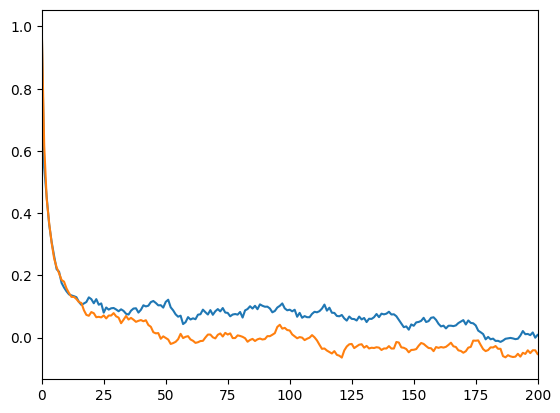

In [388]:
i = 13
j = 12 
plt.plot(az.autocorr(s8[j,..., i]))
plt.plot(az.autocorr(sa[j,..., i]))
plt.xlim(0, 200)

In [389]:
ga

array([[ 40, 138,  51, ...,  34,  36,  42],
       [ 46,  45,  48, ...,  37,  34,  43],
       [ 55,  57,  61, ..., 170,  47,  55],
       ...,
       [143,  71,  50, ...,  50,  51,  38],
       [ 43,  53,  43, ..., 110,  54,  40],
       [ 44,  45,  41, ...,  39,  40,  47]])

[]

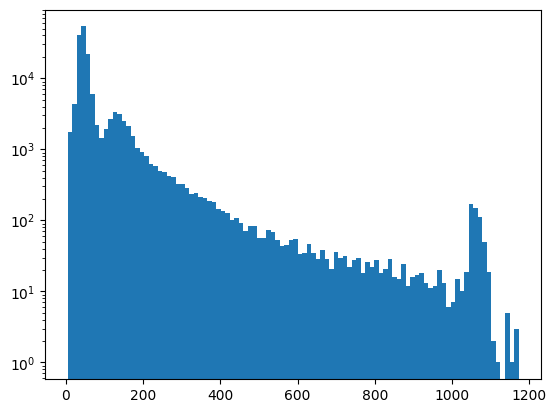

In [390]:
plt.hist(ga.flatten(), bins=100);
plt.semilogy()

In [391]:
ta.min()

0.1213208

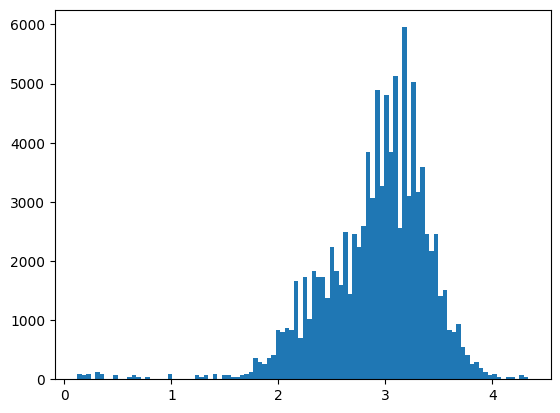

In [392]:
plt.hist(ta.flatten(), bins=100);

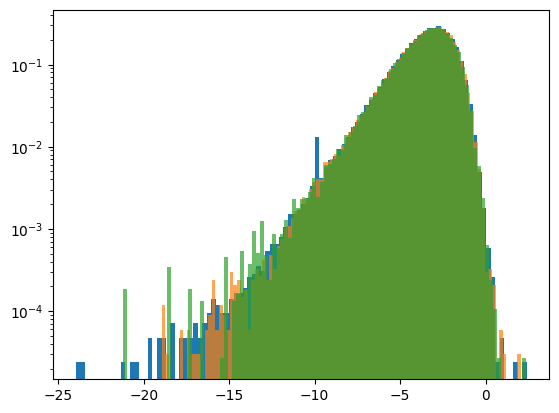

In [393]:
i = 50 
plt.hist(s1[..., i].flatten(), density=True, bins=100);
# plt.hist(sfull[..., i].flatten(), density=True, bins=100, alpha=0.7);
# plt.hist(s9[..., i].flatten(), density=True, bins=100, alpha=0.7);
plt.hist(s8[..., i].flatten(), density=True, bins=100, alpha=0.7);
plt.hist(sa[..., i].flatten(), density=True, bins=100, alpha=0.7);
# plt.hist(s8[..., i].flatten(), density=True, bins=100, alpha=0.7);
plt.yscale('log')